# NLP WINE REVIEWS

## Short Problem Statement

- The goal of this notebook is to train a machine learning model which predicts wine quality (rating) based on text review and other features (such as country or price). The target variable is ```points``` which we re-frame as a categorical variable. 
- To analyze the text reviews we use a RNN architecture. 
- We then blend this model with another tree-based classifier in order to (hopefully) improve the predictive power.  
- The data can be downloaded from [Kaggle](https://www.kaggle.com/zynicide/wine-reviews/home).
- Interesting approaches for future work: 
    * [AttentionWeightedAverage](https://www.kaggle.com/wowfattie/3rd-place).
    * [Spatial Dropout with PyTorch](https://www.kaggle.com/mlwhiz/third-place-model-for-toxic-spatial-dropout).
    * [Attention with PyTorch](https://www.kaggle.com/bminixhofer/deterministic-neural-networks-using-pytorch).

## Structure of this Notebook

[DATA LOADING](#loading)

[DATA EXPLORATION](#exploration)

[DATA EXPLORATION - Summary](#exploration-summary)

[MODEL: BENCHMARK WITH SIMPLE CLASSIFIER](#benchmark)

[MODEL: BOOSTED LGBM WITH HPO](#LGB)

[MODEL: RECURRENT NEURAL NETWORK (RNN)](#rnn)

[MODEL: RECURRENT NEURAL NETWORK (RNN) with GloVe EMBEDDING](#embedding)

[MODEL STACKING](#stacking)

[HYPERPARAMETER OPTIMIZATION FOR STACKED LGBM MODEL](#hpo)

[APPENDIX](#appendix)

# IMPORTS

In [102]:
# Standard boiler plate imports
import os
import pandas as pd
import pandas_profiling
import numpy as np
import matplotlib.pyplot as plt
# magic word for producing visualizations in notebook
%matplotlib inline

import seaborn as sns
# set plot options
plt.style.use('bmh')
import warnings
warnings.filterwarnings("ignore")
# from datetime import datetime, timedelta
import time
import random
import csv
import json
import re
from timeit import default_timer as timer

# NLTK 
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import TreebankWordTokenizer
from nltk import word_tokenize

# GENSIM
# Word2vec model for embeddings  
from gensim.models import Word2Vec
# For extracting pre-trained vectors  
from gensim.models import KeyedVectors
# PCA for dimensionality reduction
from sklearn.decomposition import PCA

# SKLEARN
from sklearn.preprocessing import Imputer, StandardScaler, MinMaxScaler, PolynomialFeatures, QuantileTransformer 
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import GradientBoostingClassifier, BaggingClassifier, RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import cross_val_score, KFold, StratifiedKFold
from sklearn.metrics import confusion_matrix, recall_score, accuracy_score, precision_score, f1_score
from sklearn.metrics import roc_curve, roc_auc_score, auc, precision_recall_curve
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.externals import joblib

# GRADIENT-BOOSTING
import lightgbm as lgb
import xgboost as xgb

# KERAS, NLP
import keras
from keras.utils import get_file, plot_model
from keras import preprocessing
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential, Model
from keras.models import load_model
from keras.layers import Embedding, Flatten, LSTM, GRU, Dense, Dropout, Masking, Activation, Input, Lambda
from keras.layers import Bidirectional, GlobalMaxPooling1D
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
# from keras.wrappers.scikit_learn import KerasClassifier
from keras.optimizers import SGD, Adam
from keras.utils import np_utils
from keras import regularizers
import keras.backend as K
import keras_metrics
from keras.utils.np_utils import to_categorical

# HPO
from hyperopt import hp
from hyperopt.pyll.stochastic import sample
from hyperopt import rand, tpe
from hyperopt import Trials
from hyperopt import fmin
from hyperopt import STATUS_OK

# EXTERNAL UTILITY
import util

# AUTO-RELOAD
# auto-reload external files: can edit the external .py file and inmediately see the changes here
%load_ext autoreload
%autoreload 2

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/martinschuetz/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<a id='loading'></a>

# DATA LOADING

- We are given two different datasets of about the same size (~150k and ~130k). 
- We load and combine them, shuffle and then split into train/dev/test sets. 
- Fix the seed for reproducability when shuffling. 

In [2]:
# Read in first data set
data1 = pd.read_csv("./wine-reviews/winemag-data_first150k.csv", index_col = False)
data1 = data1.drop(['Unnamed: 0'], axis=1)
# show data head
data1.head()

,country,description,designation,points,price,province,region_1,region_2,variety,winery
0,US,This tremendous 100% varietal wine hails from ...,Martha's Vineyard,96,235.0,California,Napa Valley,Napa,Cabernet Sauvignon,Heitz
1,Spain,"Ripe aromas of fig, blackberry and cassis are ...",Carodorum Selección Especial Reserva,96,110.0,Northern Spain,Toro,NaN,Tinta de Toro,Bodega Carmen Rodríguez
2,US,Mac Watson honors the memory of a wine once ma...,Special Selected Late Harvest,96,90.0,California,Knights Valley,Sonoma,Sauvignon Blanc,Macauley
3,US,"This spent 20 months in 30% new French oak, an...",Reserve,96,65.0,Oregon,Willamette Valley,Willamette Valley,Pinot Noir,Ponzi
4,France,"This is the top wine from La Bégude, named aft...",La Brûlade,95,66.0,Provence,Bandol,NaN,Provence red blend,Domaine de la Bégude


In [3]:
# Read in second data set
data2 = pd.read_csv("./wine-reviews/winemag-data-130k-v2.csv", index_col = False)
data2 = data2.drop(['Unnamed: 0', 'taster_name', 'taster_twitter_handle', 'title'], axis=1)
# show data head
data2.head()

,country,description,designation,points,price,province,region_1,region_2,variety,winery
0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,NaN,Sicily & Sardinia,Etna,NaN,White Blend,Nicosia
1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,NaN,NaN,Portuguese Red,Quinta dos Avidagos
2,US,"Tart and snappy, the flavors of lime flesh and...",NaN,87,14.0,Oregon,Willamette Valley,Willamette Valley,Pinot Gris,Rainstorm
3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,NaN,Riesling,St. Julian
4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Willamette Valley,Pinot Noir,Sweet Cheeks


In [4]:
print('Shape of data 1:', data1.shape)
print('Shape of data 2:', data2.shape)

Shape of data 1: (150930, 10)
Shape of data 2: (129971, 10)


In [5]:
# basic info: no missing values for text description and points (target)
data1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150930 entries, 0 to 150929
Data columns (total 10 columns):
country        150925 non-null object
description    150930 non-null object
designation    105195 non-null object
points         150930 non-null int64
price          137235 non-null float64
province       150925 non-null object
region_1       125870 non-null object
region_2       60953 non-null object
variety        150930 non-null object
winery         150930 non-null object
dtypes: float64(1), int64(1), object(8)
memory usage: 11.5+ MB


In [6]:
# basic info: no missing values for text description and points (target)
data2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129971 entries, 0 to 129970
Data columns (total 10 columns):
country        129908 non-null object
description    129971 non-null object
designation    92506 non-null object
points         129971 non-null int64
price          120975 non-null float64
province       129908 non-null object
region_1       108724 non-null object
region_2       50511 non-null object
variety        129970 non-null object
winery         129971 non-null object
dtypes: float64(1), int64(1), object(8)
memory usage: 9.9+ MB


In [7]:
# basic statistics
data1.describe()

,points,price
count,150930.000000,137235.000000
mean,87.888418,33.131482
std,3.222392,36.322536
min,80.000000,4.000000
25%,86.000000,16.000000
50%,88.000000,24.000000
75%,90.000000,40.000000
max,100.000000,2300.000000


In [8]:
# basic statistics
data2.describe()

,points,price
count,129971.000000,120975.000000
mean,88.447138,35.363389
std,3.039730,41.022218
min,80.000000,4.000000
25%,86.000000,17.000000
50%,88.000000,25.000000
75%,91.000000,42.000000
max,100.000000,3300.000000


In [9]:
# combine the two datasets
data = pd.concat([data1, data2])
# re-shuffle
data = data.sample(frac=1, random_state=42)
data.head()

,country,description,designation,points,price,province,region_1,region_2,variety,winery
9628,Australia,Although sourced from the warm northern end of...,Paradox,91,45.0,South Australia,Barossa,NaN,Shiraz,Yalumba
14801,Italy,Cerasuolo di Vittoria is a delightfully light ...,NaN,87,22.0,Sicily & Sardinia,Cerasuolo di Vittoria,NaN,Red Blend,Planeta
17771,US,In a three-pack of 2014 Pinots from Saffron Fi...,NaN,92,55.0,Oregon,Willamette Valley,NaN,Pinot Noir,Saffron Fields Vineyard
81350,US,Made in the modern style of lots of ripe tropi...,Y3,85,19.0,California,Napa Valley,Napa,Chardonnay,Jax
1888,US,"An outstanding Hellion, 44% Primitivo, 31% Pet...",The Hellion,93,22.0,Washington,Columbia Valley (WA),Columbia Valley,Red Blend,Angel Vine


In [10]:
# print shape of combined data set
print('Shape of combined data sets:', data.shape)
print('Sanity check:', data1.shape[0]+data2.shape[0])

Shape of combined data sets: (280901, 10)
Sanity check: 280901


<a id='exploration'></a>

# DATA EXPLORATION

In [11]:
def get_data_numeric(data):
    '''
    INPUT: dataframe
    OUTPUT: data with numeric features only 
    '''
    data_numeric = data.select_dtypes(include=['int64', 'float64'])
    
    numeric_var = [key for key in data_numeric.columns]

    return numeric_var, data_numeric

In [12]:
def get_data_object(data):
    '''
    INPUT: dataframe
    OUTPUT: data with object features only 
    '''
    data_object = data.select_dtypes(include=['object'])
    
    object_var = [key for key in data_object.columns]

    return object_var, data_object

In [13]:
def get_data_binary(data):
    '''
    INPUT: dataframe
    OUTPUT: list of all binary features 
    '''
    binary_var = [key for key in data.columns if len(data[key].dropna().unique())==2]
    
    data_bin = data[binary_var]
    
    return binary_var, data_bin

In [14]:
def find_low_high_cardinality_features(data, threshold):
    """
    function identifies object-type features with low and high cardinality
    INPUT: dataset
    OUTPUT: list of keys for both low and high cardinality features
    """
    
    low=[]
    high=[]
    
    for key in data.select_dtypes(include=['object']).columns:
        cardinality = len(data[key].unique())
        if cardinality <= threshold:
            low.append(key)
        else:
            high.append(key)
    
    return low, high

In [15]:
def get_cardinality_object_features(df):
    """
    function that outputs dataframe with cardinality of object type features ranked high to low
    """
     
    card=[]
    object_keys=[]
    
    for key in df.select_dtypes(include=['object']).columns:
        cardinality = len(df[key].unique())
        card.append(cardinality)
        object_keys.append(key)
    
    # We create a dictionary of Pandas Series 
    items = {'feature' : pd.Series(data = object_keys),
             'cardinality' : pd.Series(data = card)}

    df_card = pd.DataFrame(items).set_index('feature')

    # We return the DataFrame
    return df_card.sort_values(by='cardinality', ascending=False)

In [16]:
def missing_data(data):
    '''
    INPUT: dataframe
    OUTPUT: dataframe with total number and percentage of missing values
    '''
    total = data.isnull().sum().sort_values(ascending=False)
    percent = (data.isnull().sum()/data.isnull().count()*100).sort_values(ascending=False)
    
    return pd.concat([total, percent], axis=1, keys=['total', 'percent'])

In [17]:
def cols_with_missing_data(data):
    '''
    INPUT: dataframe
    OUTPUT: keys of columns with missing data
    '''
    #search for columns with missing data values
    cols_with_missing = [col for col in data.columns 
                                 if data[col].isnull().any()]
    return cols_with_missing

In [18]:
def plot_missing_values(data, number, xlabel_angle=0):
    """
    function that plots the top (number) of features with largest portion of missing values
    INPUT: dataframe, number of features to be plotted
    """
    
    #count na values, sort and take the top number
    na_counts = data.isna().sum().sort_values(ascending=False)[0:number]
    
    #define color
    base_color = sns.color_palette()[0]
    # seaborn bar plot
    sns.barplot(na_counts.index.values, na_counts, color = base_color);
    plt.xticks(rotation=xlabel_angle);

In [19]:
def plot_missing_values_rel(data, number, xlabel_angle=0):
    """
    function that plots the top (number) of features with largest portion of missing values
    INPUT: dataframe, number of features to be plotted
    """
    
    #count na values, sort and take the top number
    na_counts = data.isna().sum().sort_values(ascending=False)[0:number]
    
    #define color
    base_color = sns.color_palette()[0]
    # seaborn bar plot
    sns.barplot(na_counts.index.values, na_counts/len(data), color = base_color);
    plt.xticks(rotation=xlabel_angle);

In [20]:
def plot_categorical(data, col, size=[8 ,4], xlabel_angle=0, title='', y=False):
    '''
    use this function for ploting histogram, i.e., the count of categorical features
    '''
    plotdata = data[col].value_counts()
    plt.figure(figsize = size)
    if y==True:
        sns.barplot(y = plotdata.index, x=plotdata.values)
    else:
        sns.barplot(x = plotdata.index, y=plotdata.values)
    
    plt.title(title)
    if xlabel_angle!=0: 
        plt.xticks(rotation=xlabel_angle)
    plt.show()

In [21]:
def plot_numerical(data, col, size=[8, 4], bins=50):
    '''
    use this function for ploting the distribution of numercial features
    '''
    plt.figure(figsize=size)
    plt.title("Distribution of %s" % col)
    sns.distplot(data[col].dropna(), kde=True, bins=bins)
    plt.show()

In [22]:
def plot_categorical_bylabel(data, col, size=[12 ,6], xlabel_angle=0, title=''):
    '''
    use it to compare the distribution between label 1 and label 0
    '''
    plt.figure(figsize = size)
    l1 = data.loc[data.churn==1, col].value_counts()
    l0 = data.loc[data.churn==0, col].value_counts()
    
    plt.subplot(1,2,1)
    sns.barplot(x = l0.index, y=l0.values)
    plt.title('not-churn (Y=0): '+title)
    plt.xticks(rotation=xlabel_angle)
    
    plt.subplot(1,2,2)
    sns.barplot(x = l1.index, y=l1.values)
    plt.title('churn (Y=1): '+title)
    plt.xticks(rotation=xlabel_angle)
    plt.show()

In [23]:
def plot_categorical_bylabel_abs(data, col, size=[12 ,6], xlabel_angle=0, title='', y=False):
    '''
    use it to compare the distribution between label 1 and label 0
    '''
    
    plt.figure(figsize = size)
    l1 = data.loc[data.churn==1, col].value_counts()
    l0 = data.loc[data.churn==0, col].value_counts()
    
    base_color = sns.color_palette()[0]
    
    if y==True:
        plt.subplot(1,2,1)
        sns.barplot(y = l0.index, x=l0.values, color = base_color)
        plt.title('not-churn (Y=0): '+title)
        plt.xticks(rotation=xlabel_angle)
    
        plt.subplot(1,2,2)
        sns.barplot(y = l1.index, x=l1.values, color = base_color)
        plt.title('churn (Y=1): '+title)
        plt.xticks(rotation=xlabel_angle)
    else:
        plt.subplot(1,2,1)
        sns.barplot(x = l0.index, y=l0.values, color = base_color)
        plt.title('not-churn (Y=0): '+title)
        plt.xticks(rotation=xlabel_angle)
    
        plt.subplot(1,2,2)
        sns.barplot(x = l1.index, y=l1.values, color = base_color)
        plt.title('churn (Y=1): '+title)
        plt.xticks(rotation=xlabel_angle)
    
    plt.show()

In [24]:
def plot_categorical_bylabel_rel(data, col, size=[12 ,6], xlabel_angle=0, title='', y=False):
    '''
    use it to compare the distribution between label 1 and label 0
    '''
    
    plt.figure(figsize = size)
    l1 = data.loc[data.churn==1, col].value_counts()
    l0 = data.loc[data.churn==0, col].value_counts()
    
    base_color = sns.color_palette()[0]
    
    norm1 = len(data[data.churn==1])
    norm0 = len(data[data.churn==0])
    
    if y==True:
        plt.subplot(1,2,1)
        sns.barplot(y = l0.index, x=l0.values/norm0, color = base_color)
        plt.title('not-churn (Y=0): '+title)
        plt.xticks(rotation=xlabel_angle)
    
        plt.subplot(1,2,2)
        sns.barplot(y = l1.index, x=l1.values/norm1, color = base_color)
        plt.title('churn (Y=1): '+title)
        plt.xticks(rotation=xlabel_angle)
    else:
        plt.subplot(1,2,1)
        sns.barplot(x = l0.index, y=l0.values/norm0, color = base_color)
        plt.title('not-churn (Y=0): '+title)
        plt.xticks(rotation=xlabel_angle)
    
        plt.subplot(1,2,2)
        sns.barplot(x = l1.index, y=l1.values/norm1, color = base_color)
        plt.title('churn (Y=1): '+title)
        plt.xticks(rotation=xlabel_angle)
    
    plt.show()

In [25]:
def plot_numerical_bylabel(data, col, size=[8, 4], bins=50):
    '''
    use this function to compare the distribution of numercial features
    '''
    plt.figure(figsize=[12, 6])
    l1 = data.loc[data.churn==1, col]
    l0 = data.loc[data.churn==0, col]
    
    plt.subplot(1,2,1)
    sns.distplot(l0.dropna(), kde=True,bins=bins)
    plt.title('not-churn (Y=0): Distribution of %s' % col)
    
    plt.subplot(1,2,2)
    sns.distplot(l1.dropna(), kde=True,bins=bins)
    plt.title('churn (Y=1): Distribution of %s' % col)
    
    plt.show()

In [26]:
def get_relative_countplot(data, feature):
    '''
    function that gives RELATIVE barplot of categorical feature 
    '''
    
    #import seaborn as sb
    
    # get proportion taken by most common group for derivation of tick marks
    n_points = data.shape[0]
    max_count = data[feature].value_counts().max()
    max_prop = max_count / n_points

    # generate tick mark locations and names
    tick_props = np.arange(0, max_prop, 0.1)
    tick_names = ['{:0.2f}'.format(v) for v in tick_props]

    # create the plot
    base_color = sns.color_palette()[0]
    sns.countplot(data = data, x = feature, color = base_color);
    plt.yticks(tick_props * n_points, tick_names)
    plt.ylabel('proportion');
    plt.xticks(rotation=90);

## DATA EXPLORATION: Target

In [27]:
print("Unique values of target variable:\n", sorted(data['points'].unique().tolist()))

Unique values of target variable:
 [80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100]


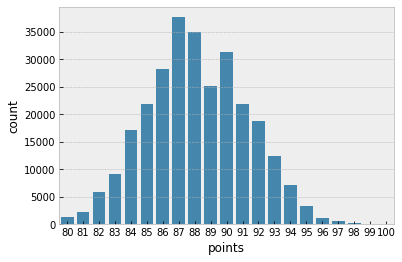

In [28]:
base_color = sns.color_palette()[0]
base_color1 = sns.color_palette()[1]
sns.countplot(data['points'], label='all data', color = base_color);

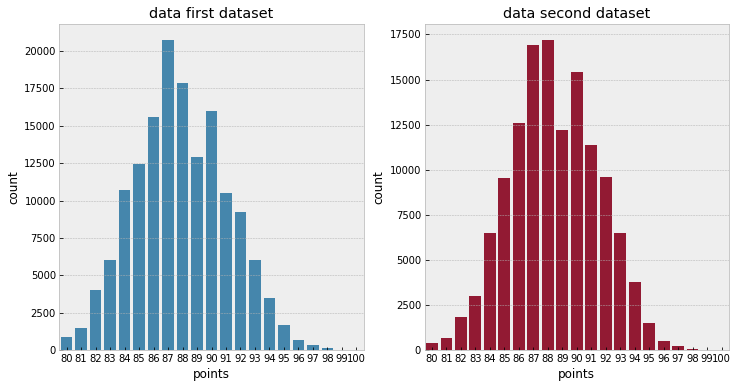

In [29]:
plt.figure(figsize=[12, 6])
plt.subplot(1,2,1)
sns.countplot(data1['points'], color = base_color);
plt.title('data first dataset')
plt.subplot(1,2,2)
sns.countplot(data2['points'], color = base_color1);
plt.title('data second dataset')
plt.show();

## DATA EXPLORATION: Target-Price correlations

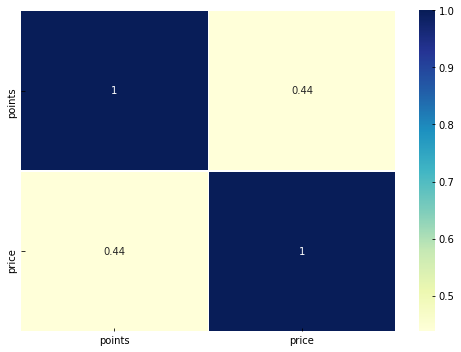

In [30]:
# check for correlations between price and point ranking
corr_mat = data.corr()
plt.figure(figsize=[7, 5])
sns.heatmap(corr_mat, annot=True,  linewidths=.5, cmap="YlGnBu", 
            annot_kws = {'alpha': 1})
plt.tight_layout();
# plt.savefig('correlations.jpg', dpi=700);

__NOTE__: There is a strong positive correlation between price and the target variable. Therefore, price should be an important feature with high predictive power. 

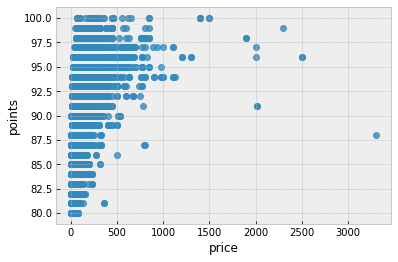

In [31]:
sns.regplot(data = data, x = 'price', y = 'points', marker='o', fit_reg=False);

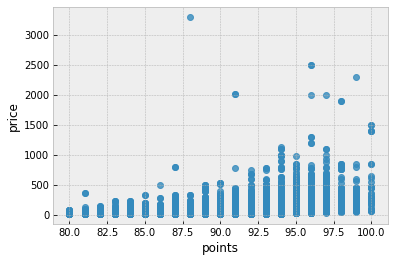

In [32]:
sns.regplot(data = data, y = 'price', x = 'points', marker='o', fit_reg=False);

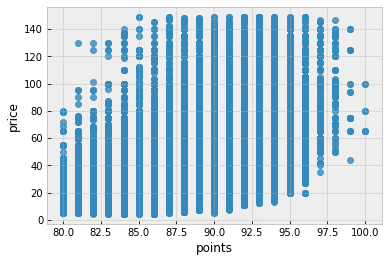

In [33]:
# Consider only data within the 98th percentile
val = data["price"].quantile(0.99)
data98 = data.loc[data['price'] < val]
sns.regplot(data = data98, y = 'price', x = 'points', marker='o', fit_reg=False);

## DATA EXPLORATION: Data types and cardinality

In [34]:
numeric_var, data_numeric = get_data_numeric(data)
object_var, data_object = get_data_object(data)

print('Shape of full data set: ', data.shape)
print('Shape of data set with numerical variables only: ', data_numeric.shape)
print('Shape of data set with object-type features only: ', data_object.shape)
print('')
print('Numerical variables: \n', numeric_var)
print('')
print('Object-type features: \n', object_var)

Shape of full data set:  (280901, 10)
Shape of data set with numerical variables only:  (280901, 2)
Shape of data set with object-type features only:  (280901, 8)

Numerical variables: 
 ['points', 'price']

Object-type features: 
 ['country', 'description', 'designation', 'province', 'region_1', 'region_2', 'variety', 'winery']


In [35]:
cut = 20
low_train, high_train = find_low_high_cardinality_features(data, cut)
print("Object-type features with low cardinality: \n", low_train)
print("Object-type features with high cardinality: \n", high_train)

Object-type features with low cardinality: 
 ['region_2']
Object-type features with high cardinality: 
 ['country', 'description', 'designation', 'province', 'region_1', 'variety', 'winery']


In [36]:
data['country'].value_counts()

US                        116901
France                     43191
Italy                      43018
Spain                      14913
Portugal                   11013
Chile                      10288
Argentina                   9431
Australia                   7286
Austria                     6402
New Zealand                 4739
Germany                     4617
South Africa                3659
Greece                      1350
Israel                      1135
Canada                       453
Hungary                      377
Romania                      259
Bulgaria                     218
Uruguay                      201
Slovenia                     181
Croatia                      162
Turkey                       142
Mexico                       133
Moldova                      130
Georgia                      129
England                       83
Brazil                        77
Lebanon                       72
Cyprus                        42
Morocco                       40
Macedonia 

In [37]:
# make dataframe with cardinalities of object-like features
cardinality = {}
for feat in data.select_dtypes(include=['object']).keys():
    number_unique = data[feat].nunique()
    cardinality[feat] = number_unique
# pandas dataframe from dictionary
df_card = pd.DataFrame.from_dict(cardinality, 
                                 orient='index', 
                                 columns=['cardinality']).sort_values(by=['cardinality'], ascending=False)
df_card

,cardinality
description,169430
designation,47239
winery,19186
region_1,1332
variety,756
province,490
country,50
region_2,18


- Obviously, the text _description_ feature has high cardinality; there are many different unique texts. Still, there seem to be duplicates. 
- We have wines (or wine ratings) from 50 different countries. 
- The feature _region2_ has low cardinality, but will be dropped becuase of an excessive number of missing NaN values (see below). 

## DATA EXPLORATION: Duplicates 

In [38]:
# number of duplicate descriptions
number_duplicate_des = data.duplicated(subset=['description']).sum()
print('Number of duplicate descriptions:', number_duplicate_des)

Number of duplicate descriptions: 111471


In [39]:
# dataframe with all text duplicates
data_text_dupl = data.loc[data.duplicated(subset=['description'])==True]
data_text_dupl = data_text_dupl.sort_values(by=['description'])
data_text_dupl.head()

,country,description,designation,points,price,province,region_1,region_2,variety,winery
96052,Austria,"""Chremisa,"" the ancient name of Krems, is comm...",Edition Chremisa Sandgrube 13,85,24.0,Niederösterreich,NaN,NaN,Grüner Veltliner,Winzer Krems
126883,US,$10 for this very drinkable Cab? That's crazy....,NaN,87,10.0,California,North Coast,North Coast,Cabernet Sauvignon,Line 39
62345,Chile,$11. Opens with a highly perfumed bouquet of l...,Estate Reserve,84,11.0,Maipo Valley,NaN,NaN,Chardonnay,La Playa
32824,US,$14 is a pretty good price for a Chardonnay th...,Whiplash,86,14.0,California,California,California Other,Chardonnay,Jamieson Ranch
126909,Spain,"). Earth, cola and leather aromas are good, ho...",Finca Resalso,86,15.0,Northern Spain,Ribera del Duero,NaN,Tinto Fino,Emilio Moro


In [40]:
# print a sample duplicate text
sample_text = data_text_dupl.loc[data_text_dupl.index==126883]['description'].values[0]
print(sample_text)

$10 for this very drinkable Cab? That's crazy. But Line 39 is exactly that, a concentrated, juicy and fruity Cab with plenty of classic Cab tannins that's an incredibly good value and probably pretty easy to find. Scoop it up when you find it, though note that two bottles were tasted here with some bottle variation.


In [41]:
# show duplicate sample
data.loc[data['description']==sample_text]

,country,description,designation,points,price,province,region_1,region_2,variety,winery
83019,US,$10 for this very drinkable Cab? That's crazy....,NaN,87,10.0,California,North Coast,North Coast,Cabernet Sauvignon,Line 39
126883,US,$10 for this very drinkable Cab? That's crazy....,NaN,87,10.0,California,North Coast,North Coast,Cabernet Sauvignon,Line 39


In [42]:
# DROP duplicate values, keeping only one row
data_no_dupl = data.drop_duplicates(subset ="description", keep = 'first', inplace = False)
data_no_dupl.head()

,country,description,designation,points,price,province,region_1,region_2,variety,winery
9628,Australia,Although sourced from the warm northern end of...,Paradox,91,45.0,South Australia,Barossa,NaN,Shiraz,Yalumba
14801,Italy,Cerasuolo di Vittoria is a delightfully light ...,NaN,87,22.0,Sicily & Sardinia,Cerasuolo di Vittoria,NaN,Red Blend,Planeta
17771,US,In a three-pack of 2014 Pinots from Saffron Fi...,NaN,92,55.0,Oregon,Willamette Valley,NaN,Pinot Noir,Saffron Fields Vineyard
81350,US,Made in the modern style of lots of ripe tropi...,Y3,85,19.0,California,Napa Valley,Napa,Chardonnay,Jax
1888,US,"An outstanding Hellion, 44% Primitivo, 31% Pet...",The Hellion,93,22.0,Washington,Columbia Valley (WA),Columbia Valley,Red Blend,Angel Vine


In [43]:
print('Shape of combined data set BEFORE removing text duplicates:', data.shape)
print('Shape of combined data set AFTER removing text duplicates:', data_no_dupl.shape)

Shape of combined data set BEFORE removing text duplicates: (280901, 10)
Shape of combined data set AFTER removing text duplicates: (169430, 10)


In [44]:
# show duplicate sample
data_no_dupl.loc[data_no_dupl['description']==sample_text]

,country,description,designation,points,price,province,region_1,region_2,variety,winery
83019,US,$10 for this very drinkable Cab? That's crazy....,NaN,87,10.0,California,North Coast,North Coast,Cabernet Sauvignon,Line 39


## DATA EXPLORATION: Missing values

In [45]:
# number of missing values: zero
number_nan_total = data.isnull().sum().sum()
print('Total number of NaN values in dataset:', number_nan_total)

Total number of NaN values in dataset: 321772


In [46]:
# missing data
missing_data(data)[0:10]

,total,percent
region_2,169437,60.319116
designation,83200,29.618976
region_1,46307,16.485167
price,22691,8.077935
province,68,0.024208
country,68,0.024208
variety,1,0.000356
winery,0,0.000000
points,0,0.000000
description,0,0.000000


In [47]:
# detect features where large fraction of values (more than 20%) are missing
dataset = data
nan_threshold = 0.2
outliers = [key for key in dataset.keys() if dataset[key].isnull().sum()/len(dataset[key]) > nan_threshold]
print(outliers)
print(len(outliers))

['designation', 'region_2']
2


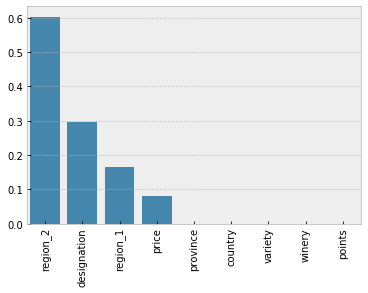

In [48]:
plot_missing_values_rel(data, 9, xlabel_angle=90)

In [49]:
# missing values after removal of duplicates
missing_data(data_no_dupl)[0:10]

,total,percent
region_2,102270,60.361211
designation,50065,29.549076
region_1,27925,16.481733
price,12810,7.560645
province,60,0.035413
country,60,0.035413
variety,1,0.000590
winery,0,0.000000
points,0,0.000000
description,0,0.000000


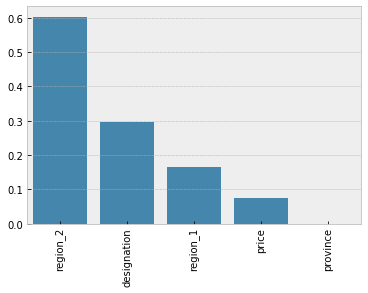

In [50]:
# missing values after removal of duplicates
plot_missing_values_rel(data_no_dupl, 5, xlabel_angle=90)

In [51]:
# missing values per row
data_no_dupl.isnull().sum(axis=1).sort_values(ascending=False)[:17]

16749     5
26486     5
85602     5
57612     5
11348     5
3131      5
27822     5
26485     5
120799    5
49510     5
129900    5
119787    5
90151     5
11150     5
13745     4
126403    4
128971    4
dtype: int64

In [52]:
# example row with 5 missing entries
data_no_dupl.loc[data_no_dupl.index == 16749]

,country,description,designation,points,price,province,region_1,region_2,variety,winery
16749,NaN,Winemaker: Bartho Eksteen. This wooded Sauvy s...,Cape Winemakers Guild Vloekskoot Wooded,91,NaN,NaN,NaN,NaN,Sauvignon Blanc,Bartho Eksteen


In [53]:
data_no_dupl.loc[data_no_dupl.index == 9628].reset_index().drop(['index'], axis=1)

,country,description,designation,points,price,province,region_1,region_2,variety,winery
0,Australia,Although sourced from the warm northern end of...,Paradox,91,45.0,South Australia,Barossa,NaN,Shiraz,Yalumba
1,Chile,"Floral, leafy, citrusy aromas lead to a fresh,...",Puerto Viejo Single Vineyard Reserve Estate Bo...,85,10.0,Maule Valley,NaN,NaN,Pinot Noir,Viña Requingua


In [54]:
# re-set the index to avoid ambiguities (same index from data set 1 and 2)
data_no_dupl = data_no_dupl.reset_index().drop(['index'], axis=1)
data_no_dupl.head()

,country,description,designation,points,price,province,region_1,region_2,variety,winery
0,Australia,Although sourced from the warm northern end of...,Paradox,91,45.0,South Australia,Barossa,NaN,Shiraz,Yalumba
1,Italy,Cerasuolo di Vittoria is a delightfully light ...,NaN,87,22.0,Sicily & Sardinia,Cerasuolo di Vittoria,NaN,Red Blend,Planeta
2,US,In a three-pack of 2014 Pinots from Saffron Fi...,NaN,92,55.0,Oregon,Willamette Valley,NaN,Pinot Noir,Saffron Fields Vineyard
3,US,Made in the modern style of lots of ripe tropi...,Y3,85,19.0,California,Napa Valley,Napa,Chardonnay,Jax
4,US,"An outstanding Hellion, 44% Primitivo, 31% Pet...",The Hellion,93,22.0,Washington,Columbia Valley (WA),Columbia Valley,Red Blend,Angel Vine


## DATA EXPLORATION: Pandas profiling

In [55]:
# run exploratory analysis with pandas profiling
pandas_profiling.ProfileReport(data)

Number of variables,11
Number of observations,280901
Total Missing (%),10.4%
Total size in memory,23.6 MiB
Average record size in memory,88.0 B
Numeric,3
Categorical,8
Boolean,0
Date,0
Text (Unique),0
Rejected,0


In [56]:
# run exploratory analysis with pandas profiling AFTER duplicate removal
pandas_profiling.ProfileReport(data_no_dupl)

Number of variables,10
Number of observations,169430
Total Missing (%),11.4%
Total size in memory,12.9 MiB
Average record size in memory,80.0 B
Numeric,2
Categorical,7
Boolean,0
Date,0
Text (Unique),1
Rejected,0


## DATA EXPLORATION: Target binning

- We aim to frame this problem as a classification problem. Therefore, we represent the target variable as a categorical one by binning this features into an somewhat arbitrary (but hopefully meanigful) number of categories. 
- TO this end we may use the ```cut``` function provided by ```pandas```.

In [57]:
bins = [0, 83, 87, 90, 94, 100]
data['rating'] = pd.cut(data['points'], bins)
data.head()

,country,description,designation,points,price,province,region_1,region_2,variety,winery,rating
9628,Australia,Although sourced from the warm northern end of...,Paradox,91,45.0,South Australia,Barossa,NaN,Shiraz,Yalumba,"(90, 94]"
14801,Italy,Cerasuolo di Vittoria is a delightfully light ...,NaN,87,22.0,Sicily & Sardinia,Cerasuolo di Vittoria,NaN,Red Blend,Planeta,"(83, 87]"
17771,US,In a three-pack of 2014 Pinots from Saffron Fi...,NaN,92,55.0,Oregon,Willamette Valley,NaN,Pinot Noir,Saffron Fields Vineyard,"(90, 94]"
81350,US,Made in the modern style of lots of ripe tropi...,Y3,85,19.0,California,Napa Valley,Napa,Chardonnay,Jax,"(83, 87]"
1888,US,"An outstanding Hellion, 44% Primitivo, 31% Pet...",The Hellion,93,22.0,Washington,Columbia Valley (WA),Columbia Valley,Red Blend,Angel Vine,"(90, 94]"


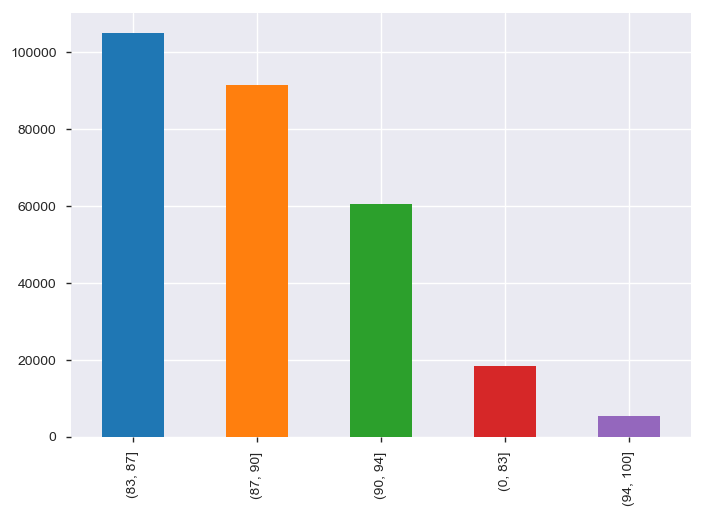

In [58]:
data['rating'].value_counts().plot(kind='bar');

In [59]:
# same procedure using apply with a custom mapping
def points_to_class(points):
    if points in range(0,83):
        return 0
    elif points in range(83,87):
        return 1
    elif points in range(87,90):
        return 2
    elif points in range(90,94):
        return 3
    else:
        return 4
    
data["rating"] = data["points"].apply(points_to_class)
data.head()

,country,description,designation,points,price,province,region_1,region_2,variety,winery,rating
9628,Australia,Although sourced from the warm northern end of...,Paradox,91,45.0,South Australia,Barossa,NaN,Shiraz,Yalumba,3
14801,Italy,Cerasuolo di Vittoria is a delightfully light ...,NaN,87,22.0,Sicily & Sardinia,Cerasuolo di Vittoria,NaN,Red Blend,Planeta,2
17771,US,In a three-pack of 2014 Pinots from Saffron Fi...,NaN,92,55.0,Oregon,Willamette Valley,NaN,Pinot Noir,Saffron Fields Vineyard,3
81350,US,Made in the modern style of lots of ripe tropi...,Y3,85,19.0,California,Napa Valley,Napa,Chardonnay,Jax,1
1888,US,"An outstanding Hellion, 44% Primitivo, 31% Pet...",The Hellion,93,22.0,Washington,Columbia Valley (WA),Columbia Valley,Red Blend,Angel Vine,3


In [60]:
data_no_dupl["rating"] = data_no_dupl["points"].apply(points_to_class)

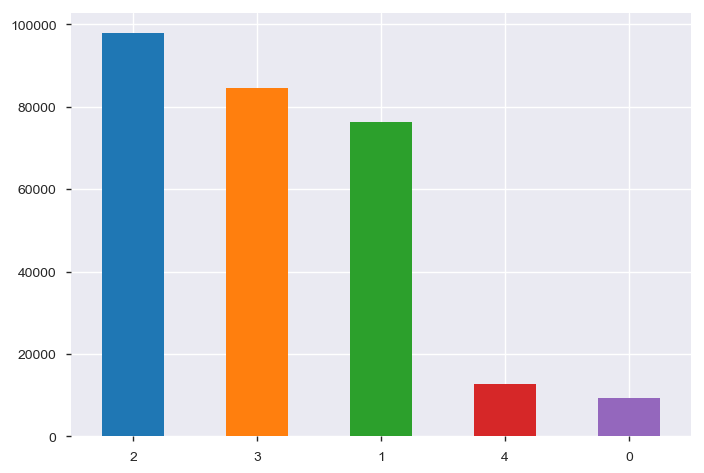

In [61]:
data['rating'].value_counts().plot(kind='bar');
plt.xticks(rotation=0);

- Class 2 is the most frequent one. 
- We can then determine the base accuracy of a feature-less, naive classifier that always predicts class 2 independent of the features as follows. 

In [62]:
# size of rating groups
data.groupby(['rating'])['points'].count().sort_values()

rating
0     9366
4    12617
1    76375
3    84638
2    97905
Name: points, dtype: int64

In [63]:
# mean price per rating group
data.groupby(['rating'])['price'].mean()

rating
0     18.413491
1     20.336913
2     27.935533
3     45.980629
4    104.730167
Name: price, dtype: float64

In [64]:
# determine accuracy of naive base classifier
number_class2 = len(data[data['rating']==2])
number_total = len(data)
acc_naive_base_cls = number_class2/number_total
print('Accuracy of feature-less, naive classifier: {:.2f}%'.format(100*acc_naive_base_cls))

Accuracy of feature-less, naive classifier: 34.85%


## DATA EXPLORATION: Country analysis

In [65]:
# prices of wine by country
prices_by_country = data_no_dupl[["price", "country"]].dropna(how = "any")

# Remove all data greater than the 98th percentile
# val = prices_by_country["price"].quantile(0.98)
# prices_by_country = prices_by_country[prices_by_country["price"] < val]

# Only consider countries where at least 100 wines have been reviewed
prices_by_country = prices_by_country.groupby("country").filter(lambda x: (x["price"].count() >= 100))

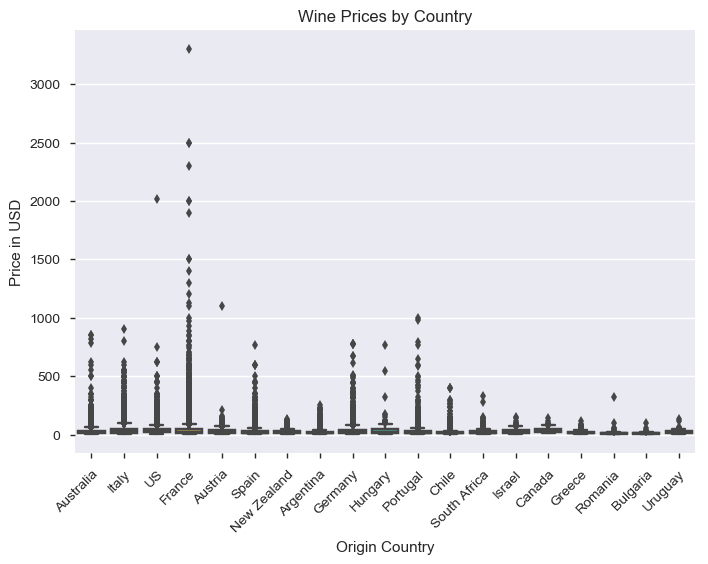

In [66]:
# Creating a boxplot
ax = sns.boxplot(x="country", y = "price", data=prices_by_country)
# Setting title 
ax.set_title("Wine Prices by Country")
# Assuming prices are in USD since its an American website
ax.set(xlabel = "Origin Country", ylabel = "Price in USD")
# Making sure ticks aren't overlapping
ax.set_xticklabels(ax.get_xticklabels(),rotation=45,ha="right",rotation_mode='anchor')
plt.show()

In [67]:
# prices of wine by country
points_by_country = data_no_dupl[["points", "country"]].dropna(how = "any")

# Remove all data greater than the 98th percentile
# val = prices_by_country["price"].quantile(0.98)
# prices_by_country = prices_by_country[prices_by_country["price"] < val]

# Only consider countries where at least 100 wines have been reviewed
prices_by_country = points_by_country.groupby("country").filter(lambda x: (x["points"].count() >= 100))

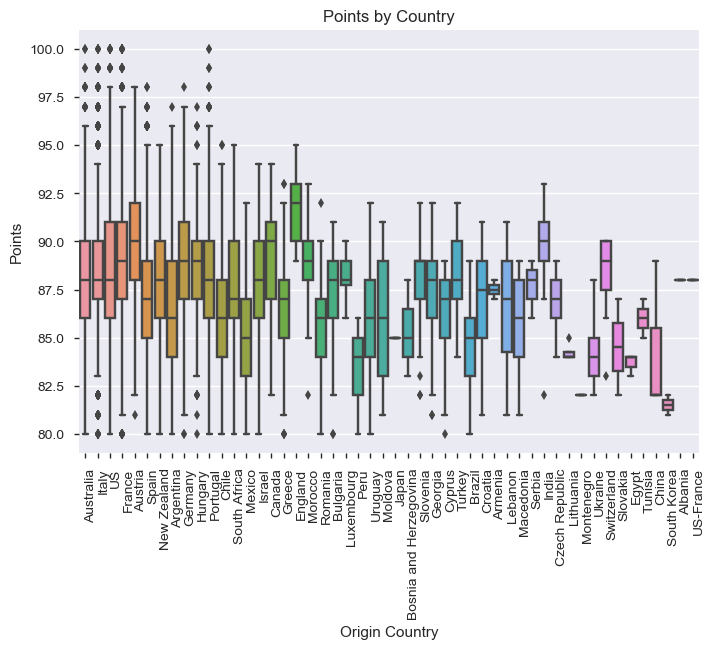

In [68]:
# Creating a boxplot
ax = sns.boxplot(x="country", y = "points", data=points_by_country)
# Setting title 
ax.set_title("Points by Country")
# Assuming prices are in USD since its an American website
ax.set(xlabel = "Origin Country", ylabel = "Points")
# Making sure ticks aren't overlapping
ax.set_xticklabels(ax.get_xticklabels(),rotation=90,ha="right",rotation_mode='anchor')
plt.show()

## DATA EXPLORATION: Text reviews

In this section we walk through some basic NLP concepts (Bag of words, tokenization, tf-idf, padding, embeddings etc.) before applying these concepts to our actual wine classification problem. 

### Simple Bag-of-Words (BOW): Example

In [69]:
# Create sample text
text_data = np.array(['I love Brazil. Brazil!',
                      'Sweden is best',
                      'Germany beats both'])

In [70]:
# Create the bag of words feature matrix
count = CountVectorizer()
bag_of_words = count.fit_transform(text_data)

# Show feature matrix
bag_of_words.toarray()

array([[0, 0, 0, 2, 0, 0, 1, 0],
       [0, 1, 0, 0, 0, 1, 0, 1],
       [1, 0, 1, 0, 1, 0, 0, 0]], dtype=int64)

In [71]:
# View Bag Of Words Matrix Column Headers
# Get feature names
feature_names = count.get_feature_names()

# View feature names
feature_names

['beats', 'best', 'both', 'brazil', 'germany', 'is', 'love', 'sweden']

In [72]:
# Create BOW data frame
pd.DataFrame(bag_of_words.toarray(), columns=feature_names)

,beats,best,both,brazil,germany,is,love,sweden
0,0,0,0,2,0,0,1,0
1,0,1,0,0,0,1,0,1
2,1,0,1,0,1,0,0,0


### Term Frequency Inverse Document Frequency: Example

- The TF-IDF approach (Term Frequency Inverse Document Frequency) extends the bag-of-words framework by taking into account total frequencies of words in the entire dataset of collected tweets. Comparing with bag-of-words, TF-IDF penalizes highly frequent words as comapred to rare words. 
- TF-IDF is an information retrieval technique that weighs a term’s frequency (TF) and its inverse document frequency (IDF). Each word has its respective TF and IDF score. The product of the TF and IDF scores of a word is called the TFIDF weight of that word.
- Put simply, the higher the TFIDF score (weight), the rarer the word and vice versa.

In [73]:
# Create sample text
text_data = np.array(['I love Brazil. Brazil!',
                      'Sweden is best',
                      'Germany beats both'])

In [74]:
# Create the tf-idf feature matrix
tfidf = TfidfVectorizer()
feature_matrix = tfidf.fit_transform(text_data)

# Show tf-idf feature matrix
feature_matrix.toarray()

array([[0.        , 0.        , 0.        , 0.89442719, 0.        ,
        0.        , 0.4472136 , 0.        ],
       [0.        , 0.57735027, 0.        , 0.        , 0.        ,
        0.57735027, 0.        , 0.57735027],
       [0.57735027, 0.        , 0.57735027, 0.        , 0.57735027,
        0.        , 0.        , 0.        ]])

In [75]:
# Show tf-idf feature matrix
tfidf.get_feature_names()

['beats', 'best', 'both', 'brazil', 'germany', 'is', 'love', 'sweden']

In [76]:
# Create tf-idf data frame
pd.DataFrame(feature_matrix.toarray(), columns=tfidf.get_feature_names())

,beats,best,both,brazil,germany,is,love,sweden
0,0.00000,0.00000,0.00000,0.894427,0.00000,0.00000,0.447214,0.00000
1,0.00000,0.57735,0.00000,0.000000,0.00000,0.57735,0.000000,0.57735
2,0.57735,0.00000,0.57735,0.000000,0.57735,0.00000,0.000000,0.00000


In [77]:
def tfidf_features(X_train, X_val, X_test):
    """
        X_train, X_val, X_test - input text       
        return TF-IDF vectorized data for each dataset
    """
    
    # filter out extremly rare words (occur less than in 5 titles)
    # filter out highly frequent words (occur more than in 90% of the tweets)
    # use 2-gram along with 1-gram with ngram_range=(1,2)
    tfidf_vectorizer = TfidfVectorizer(ngram_range=(1,2), 
                                       max_df=0.9, min_df=5, 
                                       token_pattern='(\S+)')
    
    # Fit and transform the vectorizer on the train set
    X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
    
    # Transform the test and val sets 
    X_val_tfidf = tfidf_vectorizer.transform(X_val)
    X_test_tfidf = tfidf_vectorizer.transform(X_test)
    
    return X_train_tfidf, X_val_tfidf, X_test_tfidf, tfidf_vectorizer.vocabulary_

In [78]:
# X_train_tfidf, X_val_tfidf, X_test_tfidf, tfidf_vocab = tfidf_features(X_train, X_val, X_test)

### NLTK ```TreebankWordTokenizer```

Use the NLTK [TreebankWordTokenizer](https://kite.com/python/docs/nltk.tokenize.treebank.TreebankWordTokenizer) for text cleaning. 

In [79]:
from nltk.corpus import stopwords
stopwords = set(stopwords.words('english'))

In [80]:
# some samples for the NLTK TreebankWordTokenizer
s = '''Good muffins cost $3.88\nin New York.  Please buy me\ntwo of them.\nThanks.'''
print(TreebankWordTokenizer().tokenize(s))
s = "They'll save and invest more."
print(TreebankWordTokenizer().tokenize(s))
s = "hi, my name can't hello,"
print(TreebankWordTokenizer().tokenize(s))

['Good', 'muffins', 'cost', '$', '3.88', 'in', 'New', 'York.', 'Please', 'buy', 'me', 'two', 'of', 'them.', 'Thanks', '.']
['They', "'ll", 'save', 'and', 'invest', 'more', '.']
['hi', ',', 'my', 'name', 'ca', "n't", 'hello', ',']


In [81]:
sample_text = data_no_dupl["description"].loc[data_no_dupl["description"].index == 0].values[0]
sample_text

'Although sourced from the warm northern end of Barossa, the intention is to make a less bombastic expression of Shiraz, with only 14% new French oak. Mulberry fruit still comes through, accented by hints of coffee, mint and dark chocolate, without too much extraction or tannin. Drink now–2025.'

In [82]:
word_list = word_tokenize(sample_text.lower())
' '.join(token for token in word_list if token not in stopwords and token.isalpha())

'although sourced warm northern end barossa intention make less bombastic expression shiraz new french oak mulberry fruit still comes accented hints coffee mint dark chocolate without much extraction tannin drink'

In [83]:
def clean_description(text):
    text = word_tokenize(text.lower())
    text = ' '.join(token for token in text if token not in stopwords and token.isalpha())
    return text

In [84]:
data_no_dupl["cleaned_text"] = data_no_dupl["description"].apply(clean_description)
data_no_dupl.head()

,country,description,designation,points,price,province,region_1,region_2,variety,winery,rating,cleaned_text
0,Australia,Although sourced from the warm northern end of...,Paradox,91,45.0,South Australia,Barossa,NaN,Shiraz,Yalumba,3,although sourced warm northern end barossa int...
1,Italy,Cerasuolo di Vittoria is a delightfully light ...,NaN,87,22.0,Sicily & Sardinia,Cerasuolo di Vittoria,NaN,Red Blend,Planeta,2,cerasuolo di vittoria delightfully light fresh...
2,US,In a three-pack of 2014 Pinots from Saffron Fi...,NaN,92,55.0,Oregon,Willamette Valley,NaN,Pinot Noir,Saffron Fields Vineyard,3,pinots saffron fields shows density extra comp...
3,US,Made in the modern style of lots of ripe tropi...,Y3,85,19.0,California,Napa Valley,Napa,Chardonnay,Jax,1,made modern style lots ripe tropical fruit gre...
4,US,"An outstanding Hellion, 44% Primitivo, 31% Pet...",The Hellion,93,22.0,Washington,Columbia Valley (WA),Columbia Valley,Red Blend,Angel Vine,3,outstanding hellion primitivo petite sirah zin...


In [85]:
# find most common words 
word_occurrence = data_no_dupl["cleaned_text"].str.split(expand=True).stack().value_counts()
total_words = sum(word_occurrence)
top_words = 100*word_occurrence[:30]/total_words

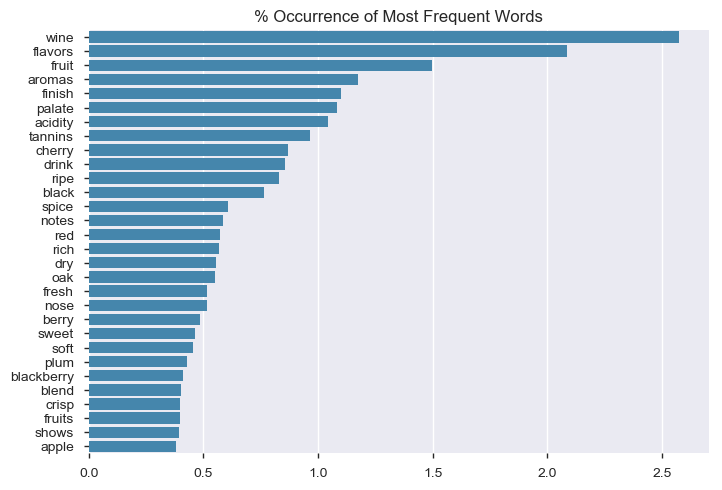

In [86]:
# plot most common words 
ax = sns.barplot(x = top_words.values, y = top_words.index, color=base_color)
ax.set_title("% Occurrence of Most Frequent Words")
plt.show()

In [87]:
# Dictionary of all words from train corpus with their counts.
words_counts = {}

from collections import Counter
words_counts = Counter([word for line in data_no_dupl["cleaned_text"] for word in line.split(' ')])

# Sorting 
most_common_words = sorted(words_counts.items(), key=lambda x: x[1], reverse=True)[:10]

# Top 10
most_common_words[:10]

[('wine', 103822),
 ('flavors', 84113),
 ('fruit', 60426),
 ('aromas', 47412),
 ('finish', 44378),
 ('palate', 43698),
 ('acidity', 42028),
 ('tannins', 38972),
 ('cherry', 34970),
 ('drink', 34454)]

### RNN approach (Keras ```Tokenizer```): Convert text to sequences

- A neural network cannot process words, so we must convert the text into integers.
- This is done using the __Keras__ utility ```Tokenizer```. By default, this will convert all words to lowercase and remove punctuation.

In [88]:
# fit Tokenizer to text
tokenizer = Tokenizer(filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n')
tokenizer.fit_on_texts(data_no_dupl["cleaned_text"])

# turn strings into lists of integer indices
sequences = tokenizer.texts_to_sequences(data_no_dupl["cleaned_text"])

In [89]:
# first review as list of integers
print(sequences[0])

[208, 619, 246, 993, 274, 2360, 10278, 180, 514, 5846, 328, 594, 114, 311, 18, 1514, 3, 81, 187, 363, 103, 123, 255, 37, 45, 361, 172, 1277, 342, 10]


In [90]:
# Example 1: Convert list of integers back to text
s = sequences[0]
' '.join(tokenizer.index_word[i] for i in s)

'although sourced warm northern end barossa intention make less bombastic expression shiraz new french oak mulberry fruit still comes accented hints coffee mint dark chocolate without much extraction tannin drink'

In [91]:
# Example 2: Convert list of integers back to text
sample = sequences[1]
' '.join(tokenizer.index_word[i] for i in sample)

'cerasuolo di vittoria delightfully light fresh red wine blend nero frappato two native sicilian grapes offers delicate berry notes cola almond paste wine pretty mineral tones close'

In [92]:
# compare length of list-of-integer encodings: Need to PAD
print('Length of first sentence:', len(sequences[0]))
print('Length of second sentence:', len(sequences[1]))

Length of first sentence: 30
Length of second sentence: 27


In [93]:
# find longest text
max_seq_length = 0
max_idx = 0 
for ii in range(len(sequences)):
    if len(sequences[ii])>max_seq_length:
        max_seq_length = len(sequences[ii])
        max_idx = ii

print('Maximum sentence length:', max_seq_length, ', at index:', max_idx)

Maximum sentence length: 73 , at index: 59628


In [94]:
# longest sentence
sample = sequences[max_idx]
' '.join(tokenizer.index_word[i] for i in sample)

'dark dusty strongly scented barrel toast coffee grounds incense substantial complete version date balancing cherry plum fruit pretty tannins glides gracefully across palate seamless finish saggi long shadows collaboration tuscany ambrogio giovanni folonari blend sangiovese cabernet sauvignon syrah new vintage percentage sangiovese climbs putting tuscany new world wine dark dusty strongly scented barrel toast coffee grounds incense substantial complete version date balancing cherry plum fruit pretty tannins glides gracefully across palate seamless finish'

In [95]:
len(max(sequences, key=len))

73

In [96]:
len(min(sequences, key=len))

2

In [97]:
# recover word index that was computed
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 35370 unique tokens.


In [98]:
# find index for single specific word
word_index['dark']

37

In [99]:
# PADDING of sequences: make all sequences of same length
maxlen = max_seq_length
seq_pad = preprocessing.sequence.pad_sequences(sequences, maxlen=maxlen)

In [100]:
print('BEFORE padding:')
print(sequences[0])
print('AFTER padding:')
print(seq_pad[0])

BEFORE padding:
[208, 619, 246, 993, 274, 2360, 10278, 180, 514, 5846, 328, 594, 114, 311, 18, 1514, 3, 81, 187, 363, 103, 123, 255, 37, 45, 361, 172, 1277, 342, 10]
AFTER padding:
[    0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0   208   619   246   993   274
  2360 10278   180   514  5846   328   594   114   311    18  1514     3
    81   187   363   103   123   255    37    45   361   172  1277   342
    10]


### Word Embedding with ```Gensim```: Visualization [Docs](https://radimrehurek.com/gensim/models/word2vec.html)

In [101]:
# define training data (corpus); here for illustration we just take the entire corpus
array_sentences = data_no_dupl["cleaned_text"].values

# tokenize array of sentences into words
tokenized_sents = [word_tokenize(i) for i in array_sentences]

In [102]:
# Defining the structure of our word2vec model 
# size: dimensionality of the word vectors
# min_count: ignores all words with total frequency lower than this
model_w2v = Word2Vec(size=8, min_count=10)
#Feeding Our coupus 
model_w2v.build_vocab(tokenized_sents)
#Lenth of the courpus 
total_examples = model_w2v.corpus_count
#traning our model
model_w2v.train(tokenized_sents, total_examples=total_examples, epochs=model_w2v.epochs)

(17122543, 20161415)

In [103]:
# for visualization fit a 2d PCA model to the vectors
# X stores the vectors of n dimensions for each word in our vocab
X = model_w2v[model_w2v.wv.vocab]

# We are reducing the n dimentions to 2d 
pca = PCA(n_components=2)
result = pca.fit_transform(X)

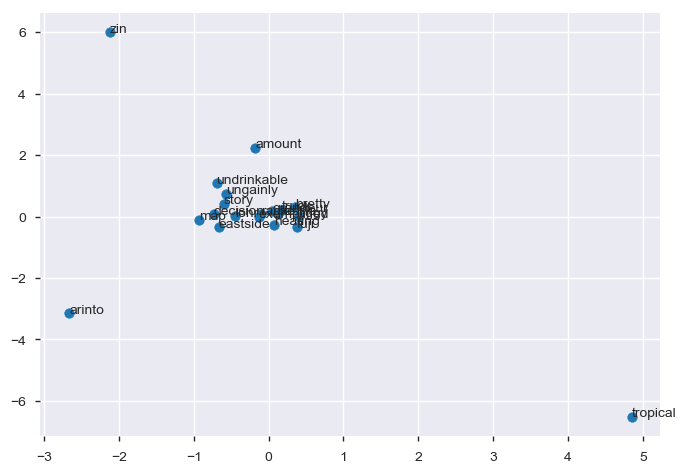

In [104]:
# create a scatter plot of the projection
plot_sample_size = 20
plt.scatter(result[:plot_sample_size, 0], result[:plot_sample_size, 1])
words = list(model_w2v.wv.vocab)[:plot_sample_size]
for i, word in enumerate(words):
    plt.annotate(word, xy=(result[i, 0], result[i, 1]));
plt.show();

In [105]:
# words included in sample plot
print(list(model_w2v.wv.vocab)[:plot_sample_size])

['story', 'lohr', 'decision', 'tropical', 'truck', 'arinto', 'pasilla', 'map', 'figgy', 'undrinkable', 'racke', 'zin', 'bretty', 'grandeur', 'exemplified', 'fuji', 'amount', 'eastside', 'ungainly', 'heating']


In [106]:
# find similarity
model_w2v.wv.most_similar(positive=['wine'], topn=5)

[('stylish', 0.9389420747756958),
 ('sumptuous', 0.9208989143371582),
 ('impressively', 0.8974703550338745),
 ('fruited', 0.8945845365524292),
 ('attractively', 0.8910669088363647)]

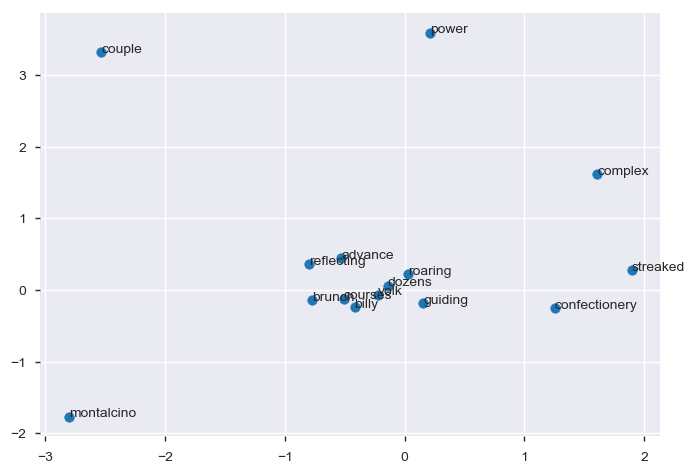

In [107]:
# plot with random subsample
sample = np.random.choice(len(result), 15, replace=False)

words_dic_sample = {};
# list(model_w2v.wv.vocab)[sample.tolist()[4]]
for entry in sample.tolist():
    word = list(model_w2v.wv.vocab)[entry]
    words_dic_sample[word] = entry

# scatter plot with annotation
plt.scatter(result[sample, 0], result[sample, 1]);
for entry in words_dic_sample:   
    idx = int(words_dic_sample[entry])
    plt.annotate(entry, xy=(result[idx, 0], result[idx, 1]));
plt.show();

<a id='exploration-summary'></a>

## DATA EXPLORATION: Summary

Here we briefly summarize our insights gained from the data exploration performed above. Specifcally, the follwing actions should be performed during the preprocessing (cleaning) of the data: 
- Load and combine the two datasets, then shuffle to get better sample of actual population. 
- Re-index to avoid ambiguities (same index for two different entries from different data sets).
- Remove text duplicates to obtain fair estimates on data never seen before. 
- Remove excessive NaN columns and rows. 
- Bin the target variable to frame the problem as a classification problem. 

In [6]:
# preprocessing (step 1): from raw data to model features
load=True

if load: 
    data_train = pd.read_csv("data_train_raw.csv", index_col = ['Unnamed: 0'])
    data_dev = pd.read_csv("data_dev_raw.csv", index_col = ['Unnamed: 0'])
else:    
    data_train, data_dev = util.load_preprocess(labelenc=True)

In [7]:
data_train.head()

,rating_0,rating_1,rating_2,rating_3,rating_4,rating,price,country,description,cleaned_text
112527,0.0,0.0,1.0,0.0,0.0,2,25.0,4,Restraint and yeastiness mingle with the zesty...,restraint yeastiness mingle zesty lemon peel n...
56033,0.0,1.0,0.0,0.0,0.0,1,28.0,47,"A simple Pinot Noir, dry and light-bodied and ...",simple pinot noir dry elegant red cherry root ...
153158,0.0,0.0,1.0,0.0,0.0,2,45.0,47,Plum and cherry fruit flavors are dressed in m...,plum cherry fruit flavors dressed malted milk ...
8603,0.0,1.0,0.0,0.0,0.0,1,26.0,47,"Sweet in fruity oak and soft in structure, thi...",sweet fruity oak soft structure easy wine flav...
113564,0.0,0.0,0.0,1.0,0.0,3,40.0,47,"From four of the producer's vineyards, this is...",four producer vineyards sublimely layered intr...


In [8]:
data_dev.head()

,rating_0,rating_1,rating_2,rating_3,rating_4,rating,price,country,description,cleaned_text
23024,0.0,0.0,0.0,1.0,0.0,3,25.0,47,"A rich blend that features toasty oak, vanilla...",rich blend features toasty oak vanilla butters...
84009,0.0,1.0,0.0,0.0,0.0,1,13.0,47,"A little too sugary sweet, but balanced with c...",little sugary sweet balanced crisp acidity fla...
10099,0.0,1.0,0.0,0.0,0.0,1,13.0,43,Jumpy berry aromas are simple and grapy. A plu...,jumpy berry aromas simple grapy plump jagged t...
103361,0.0,0.0,1.0,0.0,0.0,2,30.0,47,"Tasted prerelease, but this is already showing...",tasted prerelease already showing pretty cherr...
14448,0.0,0.0,1.0,0.0,0.0,2,23.0,23,There's a lot of excitement surrounding the li...,lot excitement surrounding groppello grape nat...


In [9]:
# simple data set
cols_simple = ['rating', 'price', 'country']
data_train_simple = data_train[cols_simple]
data_dev_simple = data_dev[cols_simple]

In [18]:
# preprocessing (step 2): from model features to RNN datasets
model_data_train, model_data_dev, word_index, idx_word, tokenizer, max_words = util.preprocess_rnn(data_train, data_dev)

In [19]:
model_data_train.head()

,rating_0,rating_1,rating_2,rating_3,rating_4,0,1,2,3,4,...,40,41,42,43,44,45,46,47,48,49
112527,0.0,0.0,1.0,0.0,0.0,0,0,0,0,0,...,7,127,1,124,29,68,1923,5,3,259
56033,0.0,1.0,0.0,0.0,0.0,0,0,0,0,0,...,9,55,2,1970,740,10,3,985,1757,290
153158,0.0,0.0,1.0,0.0,0.0,0,0,0,0,0,...,21,172,272,44,1,374,73,3377,739,1132
8603,0.0,1.0,0.0,0.0,0.0,0,0,0,0,0,...,32,152,429,32,323,1,62,179,25,44
113564,0.0,0.0,0.0,1.0,0.0,0,0,0,22,798,...,119,1466,14,2,1260,18,25,44,69,1107


In [20]:
model_data_dev.head()

,rating_0,rating_1,rating_2,rating_3,rating_4,0,1,2,3,4,...,40,41,42,43,44,45,46,47,48,49
23024,0.0,0.0,0.0,1.0,0.0,0,0,0,0,0,...,123,40,14,2,18,543,1,1138,2841,3681
84009,0.0,1.0,0.0,0.0,0.0,0,0,0,0,0,...,2,9,28,4,248,938,1950,1,62,1184
10099,0.0,1.0,0.0,0.0,0.0,0,0,0,0,0,...,67,2573,596,74,42,9,508,3,1368,18
103361,0.0,0.0,1.0,0.0,0.0,7,116,4,3,3364,...,563,15,739,263,131,90,1188,11,877,12
14448,0.0,0.0,1.0,0.0,0.0,0,0,0,0,0,...,347,6,409,7,823,113,349,1,366,510


In [13]:
# preprocessing (step 3): from model features to standard CLS datasets
model_data_train_cls, model_data_dev_cls = util.preprocess_cls(data_train, data_dev)

In [14]:
model_data_train_cls.head()

,rating,aacacia,aah,aalto,ab,abadia,abarbanel,abbacchio,abbay,abbess,...,zuc,zucca,zull,zumaya,zuri,zuriz,zwei,zwiegelt,price,country
112527,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,25.0,4
56033,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,28.0,47
153158,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,45.0,47
8603,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,26.0,47
113564,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,40.0,47


In [15]:
model_data_dev_cls.head()

,rating,aacacia,aah,aalto,ab,abadia,abarbanel,abbacchio,abbay,abbess,...,zuc,zucca,zull,zumaya,zuri,zuriz,zwei,zwiegelt,price,country
23024,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,25.0,47
84009,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13.0,47
10099,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13.0,43
103361,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,30.0,47
14448,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,23.0,23


# FEATURE ENGINEERING AND LABEL CONSTRUCTION

Under construction.

In [106]:
def missing_data_rows(data):
    '''
    INPUT: dataframe
    OUTPUT: dataframe with total number and percentage of missing values per row
    '''
    
    missing_values_row_abs = data.isnull().sum(axis=1)
    missing_values_row_percent = (data.isnull().sum(axis=1)/data.shape[1])*100
    missing_values_row = pd.concat([missing_values_row_abs, missing_values_row_percent], 
                                   axis=1, keys=['total', 'percent'])
    
    return missing_values_row

In [107]:
def clean_nan(data_in, nan_threshold=0.5):
    """
    Clean data from excessive number of NaN values (both columns and rows)
    INPUT: dataframe
    OUTPUT: dataframe where excessive NAN values have been removed
    """
    # Remove features with large portion of nan values
    nan_threshold=nan_threshold
    nan_threshold_percent = 100*nan_threshold

    # remove outlier columns:
    outliers = [key for key in data_in.keys() if data_in[key].isnull().sum()/len(data_in[key]) > nan_threshold]
    data_out = data_in.drop(outliers, axis=1)
    print("The following features have been removed (excessive NaN fraction):", outliers)
    print("Shape of incoming data:", data_in.shape)
    print("Shape after removing high-nan columns:\n", data_out.shape)

    # remove outlier rows: 
    missing_values_row = missing_data_rows(data_out)
    # introduce new column where 0(1) if low(high) NaN row
    data_out['subset'] = [1 if x >= nan_threshold_percent else 0 for x in missing_values_row['percent']]
    # split data into high and low group
    data_out_low_nan = data_out[data_out.subset==0]
    data_out_high_nan = data_out[data_out.subset==1]
    # drop subset auxiliary 
    data_out_low_nan = data_out_low_nan.drop('subset', axis=1)
    data_out_high_nan = data_out_high_nan.drop('subset', axis=1) #high-nan outliers
    print("Shape after removing high-nan rows:\n", data_out_low_nan.shape)

    
    return data_out_low_nan

In [108]:
def find_low_high_cardinality_features(data, threshold):
    """
    function identifies object-type features with low and high cardinality
    INPUT: dataset
    OUTPUT: list of keys for both low and high cardinality features
    """
    
    low=[]
    high=[]
    
    for key in data.select_dtypes(include=['object']).columns:
        cardinality = len(data[key].unique())
        if cardinality <= threshold:
            low.append(key)
        else:
            high.append(key)
    
    return low, high

In [109]:
def clean_categorical_feature_from_nan(data, key):
    """
    function that cleans categorical feature "key" from nan values by replacing NaNs with most common type
    """
    # find most common category
    idx_max = data[key].value_counts().idxmax()
    # relpace nan with most common category
    data[key].replace(np.nan, idx_max, inplace = True)
    
    return data

In [110]:
def clean_numerical_data(data_in, cols_unaffected):
    """
     cleans up numerical data: Perform imputation and normalization, 
     leaving the columns cols_unaffected unaffected
    """
    
    #do NOT manipulate target variable
    y = data_in[cols_unaffected]
    data_in.drop(columns = cols_unaffected, inplace=True)
    
    # Imputation: replace nan values with mean
    imputer = SimpleImputer()
    data_out = imputer.fit_transform(data_in)
    
    # Normalization
    scaler = StandardScaler()
    data_out = scaler.fit_transform(data_out)
        
    data_out = pd.DataFrame(data=data_out, 
                            index=data_in.index, 
                            columns=data_in.keys())

    data_out = data_out.join(y)
    
    return data_out, imputer, scaler



In [111]:
def preprocess(data, max_categories=3, nan_threshold=0.5, 
                      drop_high_card=True, normalize=True, 
                      labelEnc=True, nan_as_cat=False, 
                      verbose=True):
    """
    function to pre-process data, performing the following actions:
    - remove columns and rows with excessive nan
    - perform imputation for both categorial and numerical features
    - normalization of numerical features
    - label-encode or one-hot encoding of categorical variables
    """
    
    

        
    # CLEANING: Remove excessive NaN columns and rows where NaN fraction higher than threshold
    data = clean_nan(data, nan_threshold=nan_threshold)
        
    
    # CLEANING: drop very-high-cardinality object features
    feat_obj_low_card, feat_obj_high_card = find_low_high_cardinality_features(data, max_categories)
    if verbose:
        print('Low cardinality cat. features: \n', feat_obj_low_card)
        print('High cardinality cat. features: \n', feat_obj_high_card)
    if drop_high_card:
        data = data.drop(feat_obj_high_card, axis=1)
        print('The following features have been dropped: \n', feat_obj_high_card)
    
    
    # IMPUTATION
    feat_num = [key for key in data.select_dtypes(include=['int64','float64']).keys() if key!='TARGET']
    feat_object = [key for key in data.select_dtypes(include=['object']).keys()]
    
    
    # imputation categorical
    for key in feat_object:
        data = clean_categorical_feature_from_nan(data, key)

    # imputation numerical
    data, imputer, scaler = clean_numerical_data(data, feat_object)
    
    
    # ENCODING of categorical features
    if labelEnc:
        # LabelEncoder: Numerical Encoding for Categorical features
        feat_obj = [key for key in data.select_dtypes(include=object)]
        for key in feat_obj:
            encoder = LabelEncoder()
            data[key] = encoder.fit_transform(data[key])
        if verbose: 
            print('label-encoded categorical features:', feat_obj)
            print('label-encoded data: ', data.shape)
    else:
        # ONE-HOT ENCODING
        data, new_cat = one_hot_encoder(data, nan_as_category=nan_as_cat)
        if verbose:
            print('one hot encoded data:', data.shape)
    
    return data
    

<a id='benchmark'></a>

# MODEL: BENCHMARK WITH SIMPLE CLASSIFIER

- In this section we build a quick-and-dirty solution as a simple benchmark, based on a simple Random Forest model and a Naive Bayes model, without any HPO.
- We only account for the text feature first and then controllably add other features to our analysis. 

In [112]:
def get_metrics(y, pred):
    """
    function that prints several standard metrics:
    - accuracy
    - precision
    - recall
    - f1-score
    """
    
    # plot confusion matrix 
    print(confusion_matrix(y, pred))
    
    # print accuracy
    print('Accuracy score: {:.2f}%'.format(100*accuracy_score(y, pred)))

    # print precision
    print('Precision score: {:.2f}%'.format(100*precision_score(y, pred)))
    
    # print recall
    print('Recall score: {:.2f}%'.format(100*recall_score(y, pred)))
    
    # print f1-score
    print('F-1 score: {:.2f}%'.format(100*f1_score(y, pred)))

## SIMPLE CLASSIFIER BENCHMARK: TEXT CLEANING

In [113]:
# define cleaning function
def clean_reviews(data):
    """
    function to clean dataset
    """
    
    corpus = []
    for i in range(0, len(data)):
        review = re.sub('[^a-zA-Z]', ' ', data['description'][i])
        # review = re.sub('[^a-zA-Z]', ' ', str(data['description'][i]))
        review = review.lower()
        review = review.split()
        ps = PorterStemmer()
        # review = [ps.stem(word) for word in review if not word in set(stopwords.words('english'))]
        review = [ps.stem(word) for word in review if not word in stopwords]
        review = ' '.join(review)
        corpus.append(review)
    
    corpus = pd.DataFrame(corpus, columns=['description']) 
    result = corpus.join(data[['rating']])
    
    return result

In [114]:
# get text only data set
text_data = data_no_dupl[['rating', 'description']]
text_data.head()

,rating,description
0,3,Although sourced from the warm northern end of...
1,2,Cerasuolo di Vittoria is a delightfully light ...
2,3,In a three-pack of 2014 Pinots from Saffron Fi...
3,1,Made in the modern style of lots of ripe tropi...
4,3,"An outstanding Hellion, 44% Primitivo, 31% Pet..."


In [115]:
# clean text only data set: this takes some time
data_text_clean1 = clean_reviews(text_data)
data_text_clean1.head()

,description,rating
0,although sourc warm northern end barossa inten...,3
1,cerasuolo di vittoria delight light fresh red ...,2
2,three pack pinot saffron field show reserv lev...,3
3,made modern style lot ripe tropic fruit green ...,1
4,outstand hellion primitivo petit sirah zinfand...,3


In [ ]:
# Alternative text cleaning
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;#]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z +_]')
STOPWORDS = stopwords.words('english')
STOPWORDS.extend(['rt', 'http']) # extend stopwords; rt means re-tweet
STOPWORDS = set(STOPWORDS)

def text_prepare(text):
    """
        text: a string
        
        return: modified initial string
    """
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text
    text = BAD_SYMBOLS_RE.sub('', text) # delete symbols which are in BAD_SYMBOLS_RE from text
    text = ' '.join([word for word in text.split() if word not in STOPWORDS]) # delete stopwords from text
    text = text.strip()
    return text

In [ ]:
# apply text cleaning 
X_train = [text_prepare(text) for text in X_train]
X_dev = [text_prepare(text) for text in X_dev]
X_test = [text_prepare(text) for text in X_test]

## SIMPLE CLASSIFIER BENCHMARK: TFIDF

In [116]:
def tfidfVec(data):
    """
    function to apply TFIDF
    """

    target = data['rating']

    tfidf = TfidfVectorizer()
    tfidf.fit(data['description'])
    features = tfidf.transform(data['description'])

    return features, target

In [117]:
feats_small_clean1, target1 = tfidfVec(data_text_clean1)

In [118]:
print('Shape of X:', feats_small_clean1.shape)
print('Shape of y:', target1.shape)

Shape of X: (169430, 26070)
Shape of y: (169430,)


## SIMPLE CLASSIFIER BENCHMARK: TRAIN-TEST SPLIT

In [119]:
X_train_sc1, X_dev_sc1, Y_train_sc1, Y_dev_sc1 = train_test_split(feats_small_clean1, target1, stratify = target1,
                                                                  test_size=0.2, random_state=0)

## SIMPLE CLASSIFIER BENCHMARK: TRAINING and EVALUATION

In [125]:
def accuracy_summary(pipeline, X_train, X_test, y_train, y_test):
    """
    function to fit model, make predictions on dev set and print accuracy
    """
    # training
    sentiment_fit = pipeline.fit(X_train, y_train)
    # inference: predict
    y_pred = sentiment_fit.predict(X_test)
    # evaluate test set accuracy
    accuracy = accuracy_score(y_test, y_pred)
    # print accuracy
    print("Accuracy score on dev set: {0:.2f}%".format(accuracy*100))
    
    return accuracy

In [386]:
# random forest without HPO
rf = RandomForestClassifier()
acc = accuracy_summary(rf, X_train_sc1, X_dev_sc1, Y_train_sc1, Y_dev_sc1)

Accuracy score on dev set: 51.92%


In [127]:
# random forest without HPO
rf = RandomForestClassifier()
acc = accuracy_summary(rf, X_train_sc1, X_dev_sc1, Y_train_sc1, Y_dev_sc1)

Accuracy score on dev set: 51.79%


In [128]:
rf = RandomForestClassifier(class_weight="balanced")
acc = accuracy_summary(rf, X_train_sc1, X_dev_sc1, Y_train_sc1, Y_dev_sc1)

Accuracy score on dev set: 50.14%


In [129]:
# Naive Bayes without HPO (extremely fast)
cls = MultinomialNB()
acc = accuracy_summary(cls, X_train_sc1, X_dev_sc1, Y_train_sc1, Y_dev_sc1)

Accuracy score on dev set: 57.02%


In [126]:
# run cross-validation to check generalization of classifier
cls = MultinomialNB()
scores = cross_val_score(cls, X_train_sc1, Y_train_sc1, scoring='accuracy', n_jobs=-1, cv=5)
print('Cross-validation mean accuracy {0:.2f}%, std {1:.2f}.'.format(np.mean(scores) * 100, np.std(scores) * 100))

Cross-validation mean accuracy 56.58%, std 0.12.


### Classification with Systematically Preprocessed Dataset

In [12]:
# classification with preproccessed data using util functions
Y_train = model_data_train_cls['rating']
Y_dev = model_data_dev_cls['rating']
X_train = model_data_train_cls.drop(['rating'], axis=1)
X_dev = model_data_dev_cls.drop(['rating'], axis=1)

In [13]:
X_train.head()

,aacacia,aah,aalto,ab,abadia,abarbanel,abbacchio,abbay,abbess,abbinar,...,zuc,zucca,zull,zumaya,zuri,zuriz,zwei,zwiegelt,price,country
112527,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,25.0,4
56033,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,28.0,47
153158,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,45.0,47
8603,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,26.0,47
113564,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,40.0,47


In [ ]:
# XGB without HPO
cls = xgb.XGBClassifier()
acc = util.accuracy_summary(cls, X_train, X_dev, Y_train, Y_dev)

## SIMPLE CLASSIFIER BENCHMARK: END-to-END PIPELINE

Under construction.

In [ ]:
# define simple end-to-end pipeline starting from raw data
def pipeline(data):
    """
    simple end-to-end pipeline as benchmark
    """
    
    # clean data
    data = data.drop(['qid'], axis=1)
    X = data['question_text']
    Y = data['target']
    
    # train/test split
    X_train, X_dev, Y_train, Y_dev = train_test_split(X, Y, stratify = Y,
                                                      test_size=0.2, random_state=0)
        
    # PIPELINE
    cv = CountVectorizer(max_features=30000, ngram_range=(1, 3))

    pipeline = Pipeline([
            ('vectorizer', cv),
            ('classifier', rf)])
    
    # TRAINING
    model = pipeline.fit(X_train, Y_train)
    
    # predictions training-set
    Y_train_pred = model.predict(X_train)
    Y_train_pred_proba = model.predict_proba(X_train)[:, 1]
    
    # predictions dev-set
    Y_dev_pred = model.predict(X_dev)
    Y_dev_pred_proba = model.predict_proba(X_dev)[:, 1]

    
    ###METRICS###
    # print accuracies TRAINING set
    print('Predictions TRAINING SET:')
    get_metrics(Y_train, Y_train_pred)
    print('')
    
    # print accuracies DEV set
    print('Predictions DEV SET:')
    get_metrics(Y_dev, Y_dev_pred)
    print('')
    
    # print number of true positives and positive predictions
    print('Number of true positives (Y=1) in dev set:', Y_dev.sum())
    print('Number of predicted positives (Y=1) in dev set:', Y_dev_pred.sum())

    # Plot ROC Curve
    fpr, tpr, thresholds = roc_curve(Y_dev, Y_dev_pred_proba)
    plt.plot(fpr, tpr)
    plt.xlabel('false positive rate')
    plt.ylabel('true positive rate')
    #plt.tight_layout();
    #plt.savefig('roc_rf_small.jpg', dpi=700);
    
    # print AUC
    AUC = roc_auc_score(Y_dev, Y_dev_pred_proba)
    print("AUC on dev set: {:.3f}".format(AUC))

In [ ]:
pipeline(data_small)

<a id='LGB'></a>

# MODEL: BOOSTED LGBM WITH HPO

Under construction.

In [ ]:
# PREPROCESSING 
def preprocess_data(vec_params, number_samples=100000):
    """
    function that loads and preprocesses raw data set, then uploads to S3.  
    Optional parameters:
    - number_samples: dataset size to keep
    - vec_params: parameters defining the Vectorizer object
    """
    
    ###LOADING and PREPROCESSING###
    # LOAD DATA
    data = pd.read_csv('data-kaggle-quora/train.csv')
    # print original data shape
    print('Shape of original data set:', data.shape)
    
    # take only subset of data
    data = data.sample(n=number_samples, random_state=42)
    print('Shape of random sub-set:', data.shape)
    
    # clean data
    data = data.drop(['qid'], axis=1)
    X = data['question_text']
    Y = data['target']
    
    # train/test split
    X_train, X_dev, Y_train, Y_dev = train_test_split(X, Y, stratify = Y,
                                                      test_size=0.2, random_state=0)
    
    # Bag of words: Text vectorization
    # TfidfVectorizer equivalent to CountVectorizer followed by TfidfTransformer
    
    # parameters for TfidfVectorizer
    min_df = vec_params['min_df']
    max_df = vec_params['max_df']
    stop_words = vec_params['stop_words']
    max_features = vec_params['max_features']
    # define TfidfVectorizer object
    tfidf = TfidfVectorizer(stop_words=stop_words, 
                            min_df=min_df, 
                            max_df=max_df,
                            max_features=max_features)
        
    tfidf.fit(X_train)
    X_train = tfidf.transform(X_train).toarray()
    X_dev = tfidf.transform(X_dev).toarray()
    print('Shape of X_train (BoW):', X_train.shape)
    print('Shape of X_dev (BoW):', X_dev.shape)
    
    # merge X and Y with target Y in first column
    X_train = pd.DataFrame(data=X_train)
    Y_train = pd.DataFrame(data=Y_train)
    X_dev = pd.DataFrame(data=X_dev)
    Y_dev = pd.DataFrame(data=Y_dev)
    
    data_train = Y_train.join(X_train)
    data_dev = Y_dev.join(X_dev)
    
    # IMPUTATION
    data_train = data_train.fillna(0)
    data_dev = data_dev.fillna(0)
    
    # metadata for storing data preparation
    data_dict = vec_params
    data_dict['number_samples'] = number_samples
    data_dict['bucket'] = bucket
    data_dict['prefix'] = prefix
    
    
    
    ###UPLOAD TO S3###
    filename_train = 'train_'+str(number_samples)+'_'+str(int(min_df))+'_'+str(int(max_df))+'.csv'
    filename_val = 'validation_'+str(number_samples)+'_'+str(int(min_df))+'_'+str(int(max_df))+'.csv'
    print(filename_train)
    print(filename_val)
    
    # write to csv
    data_train.to_csv(filename_train, header=False, index=False)
    data_dev.to_csv(filename_val, header=False, index=False)

    # upload these files to S3
    s3 = boto3.Session().resource('s3')
    s3bucket = s3.Bucket(bucket)
    # set train path
    train_path = os.path.join(prefix,'trainXGB/'+filename_train)
    # upload training data
    s3bucket.Object(train_path).upload_file(filename_train)
    # set validation path
    train_path = os.path.join(prefix,'validationXGB/'+filename_val)
    # upload validation data
    s3bucket.Object(train_path).upload_file(filename_val)

    # SageMaker needs to know where the training and validation data are located
    # point to location of training data
    s3_train_path = 's3://{}/{}/trainXGB'.format(bucket,prefix)
    s3_input_train = sagemaker.s3_input(s3_data = s3_train_path, content_type='csv')
    # point to location of validation data
    s3_validation_path = 's3://{}/{}/validationXGB'.format(bucket,prefix)
    s3_input_validation = sagemaker.s3_input(s3_data = s3_validation_path, content_type='csv')

    s3_data = {'train': s3_input_train, 'validation': s3_input_validation}
    
    
    
    return data_train, data_dev, data_dict, tfidf, s3_data

In [ ]:
# load, preprocess and upload to s3
vec_params = {'stop_words': 'english', #default: None
              'min_df': 1, # default: 1
              'max_df': 1.0, # default: 1.0
              'max_features': 1000} # default: None
data_train, data_dev, data_dict, vectorizer, s3_data = preprocess_data(vec_params)
data_train.head()

In [ ]:
vectorizer.get_feature_names()[100:107] 

<a id='rnn'></a>

--- 
# MODEL: RECURRENT NEURAL NETWORK (RNN)

- Keras __Embedding Layer__ offers an ```Embedding``` layer that can be used for neural networks on text data.
- It requires that the input data be integer encoded, so that each word is represented by a unique integer. This data preparation step can be performed using the ```Tokenizer``` API also provided with Keras.
- The Embedding layer is initialized with random weights and will learn an embedding for all of the words in the training dataset.
- It is a flexible layer that can be used in a variety of ways, such as:
    * It can be used alone to learn a word embedding that can be saved and used in another model later.
    * It can be used as part of a deep learning model where the embedding is learned along with the model itself.
    * It can be used to load a pre-trained word embedding model, a type of transfer learning.
- The __Embedding layer is defined as the first hidden layer of a network__. It must specify 3 arguments:
    * __input_dim__: This is the size of the vocabulary in the text data. For example, if your data is integer encoded to values between 0-10, then the size of the vocabulary would be 11 words.
    * __output_dim__: This is the size of the vector space in which words will be embedded. It defines the size of the output vectors from this layer for each word. For example, it could be 32 or 100 or even larger. Test different values for your problem (HPO).
    * __input_length__: This is the length of input sequences, as you would define for any input layer of a Keras model. For example, if all of your input documents are comprised of 1000 words, this would be 1000. For example, below we define an Embedding layer with a vocabulary of ```max_features``` (e.g. integer encoded words from 0 to ```max_features```, inclusive), a vector space of 32 dimensions in which words will be embedded, and input documents that have ```maxlen``` words each.
- The Embedding layer has weights that are learned. If you save your model to file, this will include weights for the Embedding layer.
- The output of the Embedding layer is a 2D vector with one embedding for each word in the input sequence of words (input document).
- If you wish to connect a Dense layer directly to an Embedding layer, you must first flatten the 2D output matrix to a 1D vector using the Flatten layer.

In [29]:
# PREPROCESSING FOR RNN

# set number of words to consider as features
max_features = 10000
# Cut off the text after this max number of words (among the max_features most common words)
maxlen = 50

###TEXT PREPROCESSING
# define and fit Tokenizer object to text
tokenizer = Tokenizer(num_words=max_features, split=' ')
tokenizer.fit_on_texts(text_data['description'])
# recover word index that was computed
word_index = tokenizer.word_index

# turn strings into lists of integer indices
X = tokenizer.texts_to_sequences(text_data['description'])
# PADDING of sequences
X = pad_sequences(X, maxlen=maxlen)

# target variable
Y = text_data['rating']
# one-hot encoding of target variable
y = to_categorical(Y)
# Y = pd.get_dummies(Y)

# train/test split
X_train, X_dev, Y_train, Y_dev = train_test_split(X, y, test_size=0.2, random_state=0)

In [30]:
print('Shape of original (small) data:', text_data.shape)
print('Shape after tokenization:', X.shape)
print('First example: ', X[0])
print('Print train shape:', X_train.shape, Y_train.shape)
print('Print dev shape:', X_dev.shape, Y_dev.shape)

Shape of original (small) data: (169430, 2)
Shape after tokenization: (169430, 50)
First example:  [   0    0    0  268  729   22    2  290 1156  315    4 2679    2    7
   11  234    3  607 6373  406    4  691    5  357 1051  161  379   39
 1737   13  125  241   70  437   31  154    4  169  309    1   57   76
  443  222  223 1461   80  389   25 2481]
Print train shape: (135544, 50) (135544, 5)
Print dev shape: (33886, 50) (33886, 5)


In [34]:
### DEFINE RNN-BASED NETWORK
embedding_size = 100
lstm_out = 100
number_out = 5
number_dense = 50
dropout = 0.3

model = Sequential()
# define embedding layer: takes at least two arguments...
# - number of possible tokens
# - dimensionality of the embedding
# specify the maximum input length to the embedding layer so you can later flatten the embedded inputs
model.add(Embedding(max_features, embedding_size, input_length = maxlen))
# LSTM layer
model.add(LSTM(lstm_out, 
               return_sequences=False, 
               recurrent_dropout=dropout, dropout=dropout))
# Fully connected layer
model.add(Dense(number_dense, activation='relu'))
# Dropout for regularization
model.add(Dropout(0.5))
# output layer
model.add(Dense(number_out, activation='softmax'))

# compile the model
model.compile(loss='categorical_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 50, 100)           1000000   
_________________________________________________________________
lstm_2 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_3 (Dense)              (None, 50)                5050      
_________________________________________________________________
dropout_2 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 5)                 255       
Total params: 1,085,705
Trainable params: 1,085,705
Non-trainable params: 0
_________________________________________________________________
None


In [35]:
# TRAINING
batch_size = 32
epochs = 10 

callbacks = [EarlyStopping(monitor='val_loss', patience=3),
             ModelCheckpoint('rnn_model.h5', save_best_only=True, save_weights_only=False)]

history = model.fit(X_train, Y_train, epochs = epochs, 
                    batch_size=batch_size, validation_split=0.1, verbose = 1,
                    callbacks = callbacks)

Train on 121989 samples, validate on 13555 samples
Epoch 1/10
121989/121989 [==============================] - 295s 2ms/step - loss: 0.9326 - acc: 0.5894 - val_loss: 0.8059 - val_acc: 0.6406
Epoch 2/10
121989/121989 [==============================] - 283s 2ms/step - loss: 0.8101 - acc: 0.6450 - val_loss: 0.7775 - val_acc: 0.6622
Epoch 3/10
121989/121989 [==============================] - 296s 2ms/step - loss: 0.7637 - acc: 0.6694 - val_loss: 0.7736 - val_acc: 0.6607
Epoch 4/10
121989/121989 [==============================] - 285s 2ms/step - loss: 0.7273 - acc: 0.6869 - val_loss: 0.7715 - val_acc: 0.6592
Epoch 5/10
121989/121989 [==============================] - 279s 2ms/step - loss: 0.6913 - acc: 0.7024 - val_loss: 0.7885 - val_acc: 0.6579
Epoch 6/10
121989/121989 [==============================] - 278s 2ms/step - loss: 0.6573 - acc: 0.7178 - val_loss: 0.8318 - val_acc: 0.6527
Epoch 7/10
121989/121989 [==============================] - 288s 2ms/step - loss: 0.6277 - acc: 0.7318 - val_

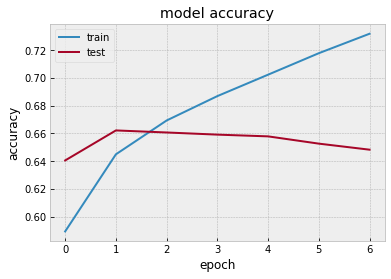

In [36]:
# summarize history for Accuracy
#fig_acc = plt.figure(figsize=(5, 5))
plt.plot(history.history['acc']);
plt.plot(history.history['val_acc']);
plt.title('model accuracy');
plt.ylabel('accuracy');
plt.xlabel('epoch');
plt.legend(['train', 'test'], loc='upper left');
plt.show();

In [37]:
# INFERENCE: score on test set
score, acc = model.evaluate(X_dev, Y_dev, verbose = 0)
print("Score on dev set: %.2f" % (score))
print("Accuracy on dev set: %.4f" % (acc))

Score on dev set: 0.85
Accuracy on dev set: 0.6497


In [45]:
# Predictions
pred_dev_proba = model.predict(X_dev) # probabilities
pred_dev = model.predict_classes(X_dev) # classes with highest prob

# Actual
true_dev = [np.argmax(x) for x in Y_dev]

# Find accuracies
accuracy = accuracy_score(true_dev, pred_dev)

In [47]:
# cosnistency check
print("Accuracy on dev set: %.4f" % (accuracy))

Accuracy on dev set: 0.6497


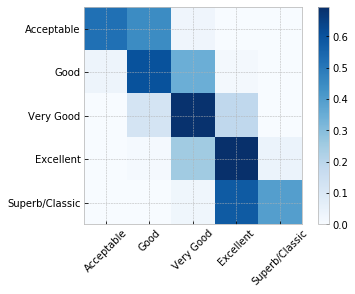

In [49]:
# get confusion matrix
cm = confusion_matrix(true_dev, pred_dev)
# normalize confusion matrix
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# plot confusion matrix
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
class_name = ["Acceptable", "Good", "Very Good", "Excellent", "Superb/Classic"]
plt.colorbar()
tick_marks = np.arange(len(class_name))
plt.xticks(tick_marks, class_name, rotation=45)
plt.yticks(tick_marks, class_name)
plt.show()

In [50]:
confusion_matrix(true_dev, pred_dev)

array([[ 535,  461,   28,    2,    0],
       [ 308, 5414, 3111,  136,    3],
       [   7, 1461, 8124, 2187,   16],
       [   0,   96, 2686, 7342,  443],
       [   0,    2,   38,  885,  601]])

<a id='embedding'></a>

# MODEL: RECURRENT NEURAL NETWORK (RNN) with ```GloVe```

- In this section we apply text pre-processing to the full data-set (using the Keras ```Tokenizer```), split into train and dev-set and upload to AWS S3. Careful: Data leakage possible.
- Load GloVe word embedding to build __pre-trained embedding__ matrix for RNN embedding layer.

In [120]:
# inspect again original data
text_data.head()

,rating,description
0,3,Although sourced from the warm northern end of...
1,2,Cerasuolo di Vittoria is a delightfully light ...
2,3,In a three-pack of 2014 Pinots from Saffron Fi...
3,1,Made in the modern style of lots of ripe tropi...
4,3,"An outstanding Hellion, 44% Primitivo, 31% Pet..."


In [121]:
### DATA SPLITTING
# NOTE: to avoid data leakage we have to split data before tokenizing

# text features
X = text_data['description']
# target variable
Y = text_data['rating']
# one-hot encoding of target variable
y = to_categorical(Y)

# train/test split
X_train, X_dev, Y_train, Y_dev = train_test_split(X, y, test_size=0.2, random_state=0)

In [122]:
###TEXT PREPROCESSING

# set number of words to consider as features
max_words = 10000
# Cut off the text after this max number of words (among the max_features most common words)
maxlen = 50

# define and fit Tokenizer object to TRAIN text
tokenizer = Tokenizer(num_words=max_words, split=' ')
tokenizer.fit_on_texts(X_train)
# recover word index that was computed
word_index = tokenizer.word_index
idx_word = tokenizer.index_word

# turn strings into lists of integer indices
X_train = tokenizer.texts_to_sequences(X_train)
X_dev = tokenizer.texts_to_sequences(X_dev)
# PADDING of sequences
X_train = pad_sequences(X_train, maxlen=maxlen)
X_dev = pad_sequences(X_dev, maxlen=maxlen)

In [123]:
print('Shape of original (small) data:', text_data.shape)
# print('Shape after tokenization:', X.shape)
print('First example: ', X_train[0])
print('Print train shape:', X_train.shape, Y_train.shape)
print('Print dev shape:', X_dev.shape, Y_dev.shape)

Shape of original (small) data: (169430, 2)
First example:  [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
 1622    1 3465 1069    5    2  302   86  369   43    2   19    7  127
    1  124   29   68 1923    5    3  259]
Print train shape: (135544, 50) (135544, 5)
Print dev shape: (33886, 50) (33886, 5)


In [124]:
# create dataframe after padding with target as first column
# training set
features_train = pd.DataFrame(data=X_train)
target_train = pd.DataFrame(data=Y_train)
model_data_train = target_train.join(features_train, lsuffix='_target')
# dev set
features_dev = pd.DataFrame(data=X_dev)
target_dev = pd.DataFrame(data=Y_dev)
model_data_dev = target_dev.join(features_dev, lsuffix='_target')

model_data_train.head()

,0_target,1_target,2_target,3_target,4_target,0,1,2,3,4,...,40,41,42,43,44,45,46,47,48,49
0,0.0,0.0,1.0,0.0,0.0,0,0,0,0,0,...,7,127,1,124,29,68,1923,5,3,259
1,0.0,1.0,0.0,0.0,0.0,0,0,0,0,0,...,9,55,2,1970,740,10,3,985,1757,290
2,0.0,0.0,1.0,0.0,0.0,0,0,0,0,0,...,21,172,272,44,1,374,73,3377,739,1132
3,0.0,1.0,0.0,0.0,0.0,0,0,0,0,0,...,32,152,429,32,323,1,62,179,25,44
4,0.0,0.0,0.0,1.0,0.0,0,0,0,22,798,...,119,1466,14,2,1260,18,25,44,69,1107


In [129]:
# Example: Convert single row of dataframe of integers back to text
sample = model_data_train.iloc[1].tolist()
' '.join(tokenizer.index_word[i] for i in sample if i!=0)

"and a simple pinot noir dry and light bodied and elegant with red cherry root beer mint pepper and vanilla flavors shows the variety's personality in a direct likeable way"

## Build embedding matrix

- There are numerous embeddings you can find online trained on different corpuses (large bodies of text).
- The ones we will use are available from Stanford and come in 100, 200, or 300 dimensions. These embeddings are from the ```GloVe``` (Global Vectors for Word Representation) algorithm and were trained on Wikipedia.
- Even though the pre-trained embeddings contain 400,000 words, there are some words in our vocab that are not included. When we represent these words with embeddings, they will have 100-d vectors of all zeros. This problem can be overcome by training our own embeddings or by setting the ```Embedding``` layer's trainable parameter to True (and removing the Masking layer).
- We can quickly load in the pre-trained embeddings from disk and make an embedding matrix with the following code. 

In [132]:
# build embedding dictionary with embedding dimension=300
embedding_dim = 300 
file = open('glove.840B.300d.txt', encoding = "utf8")

embeddings_index = {}
for line in file:
    values = line.split()
    # word = values[0]
    # coefs = np.asarray(values[1:], dtype='float32')
    word = ''.join(values[:-embedding_dim])
    coefs = np.asarray(values[-embedding_dim:], dtype='float32')
    embeddings_index[word] = coefs
    
file.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 2195892 word vectors.


In [133]:
# construct embedding matrix
not_found = 0

embedding_matrix = np.zeros((max_words, embedding_dim))
for word, i in word_index.items():
    if i < max_words:
        embedding_vector = embeddings_index.get(word)
        # words not found in the glove embedding index will be all zeros
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
        else:
            not_found += 1

print('There were %s words without pre-trained embeddings.' % not_found)

There were 820 words without pre-trained embeddings.


In [134]:
# For illustration, we can find the closest words to a given word in embedding space using the cosine distance. 
# This requires first normalizing the vectors to have a magnitude of 1.

# Normalize and convert nan to 0
embedding_matrix_norm = embedding_matrix / np.linalg.norm(embedding_matrix, axis=1).reshape((-1, 1))
embedding_matrix_norm = np.nan_to_num(embedding_matrix_norm)

In [135]:
def find_closest(query, embedding_matrix, word_idx, idx_word, n=10):
    """
    Find closest words to a query word in embeddings
    """

    idx = word_idx.get(query, None)
    # Handle case where query is not in vocab
    if idx is None:
        print('%s not found in vocab.' % query)
        return
    else:
        vec = embedding_matrix[idx]
        # Handle case where word doesn't have an embedding
        if np.all(vec == 0):
            print('%s has no pre-trained embedding.' % query)
            return
        else:
            # Calculate distance between vector and all others
            dists = np.dot(embedding_matrix, vec)

            # Sort indexes in reverse order
            idxs = np.argsort(dists)[::-1][:n]
            sorted_dists = dists[idxs]
            closest = [idx_word[i] for i in idxs]

    print('Query: %s \n' % query)
    max_len = max([len(i) for i in closest])
    # Print out the word and cosine distances
    for word, dist in zip(closest, sorted_dists):
        print('Word:', word, 'with cosine Similarity:', round(dist, 4))

In [136]:
find_closest('wine', embedding_matrix_norm, word_index, idx_word, 10)

Query: wine 

Word: wine with cosine Similarity: 1.0
Word: wines with cosine Similarity: 0.8459
Word: tasting with cosine Similarity: 0.7604
Word: winery with cosine Similarity: 0.6953
Word: grape with cosine Similarity: 0.6845
Word: champagne with cosine Similarity: 0.674
Word: grapes with cosine Similarity: 0.663
Word: beer with cosine Similarity: 0.6601
Word: tastings with cosine Similarity: 0.6466
Word: pinot with cosine Similarity: 0.645


### Store and Load Embedding Matrix

In [37]:
embedding_matrix = util.build_glove_embedding(word_index=word_index, max_words=max_words)
print('Shape of embedding matrix:', embedding_matrix.shape)

There were 820 words without pre-trained embeddings.
Shape of embedding matrix: (10000, 300)


In [38]:
# load model (JOBLIB)
filename = 'glove_embedding_matrix'
loaded_embedding = joblib.load(filename)

In [41]:
# find similar words 
# Normalize and convert nan to 0
embedding_matrix_norm = embedding_matrix / np.linalg.norm(embedding_matrix, axis=1).reshape((-1, 1))
embedding_matrix_norm = np.nan_to_num(embedding_matrix_norm)

util.find_closest('beer', embedding_matrix_norm, word_index, idx_word, 10)

Query: beer 

Word: beer with cosine Similarity: 1.0
Word: drink with cosine Similarity: 0.7515
Word: brew with cosine Similarity: 0.748
Word: drinks with cosine Similarity: 0.7175
Word: ale with cosine Similarity: 0.7164
Word: drinking with cosine Similarity: 0.6878
Word: brewed with cosine Similarity: 0.6742
Word: wine with cosine Similarity: 0.6601
Word: beverage with cosine Similarity: 0.6599
Word: bottle with cosine Similarity: 0.6526


### Refinement of ```GloVe``` embedding

- When preprocessing was done for glove, the creators didn’t convert the words to lowercase. That means that it contains multiple variations of a word like ‘USA’, ‘usa’ and ‘Usa’. That also means that in some cases while a word like ‘Word’ is present, its analog in lowercase i.e. ‘word’ is not present. We can get through this situation by using the below code.
- One might also derive value by adding extra information to the embeddings using some domain knowledge and NLP skills. For example, we can add external knowledge to the embeddings themselves by adding polarity and subjectivity of a word from the ```TextBlob``` package in Python.
- Interesting read [here](https://towardsdatascience.com/what-my-first-silver-medal-taught-me-about-text-classification-and-kaggle-in-general-ebae0df16278).

In [ ]:
from textblob import TextBlob

def create_glove(word_index,embeddings_index):
    emb_mean,emb_std = -0.005838499,0.48782197
    all_embs = np.stack(embeddings_index.values())
    embed_size = all_embs.shape[1]
    nb_words = min(max_features, len(word_index))
    embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size+4))
    
    count_found = nb_words
    for word, i in tqdm(word_index.items()):
        if i >= max_features: continue
        embedding_vector = embeddings_index.get(word)
        word_sent = TextBlob(word).sentiment
        # Extra information we are passing to our embeddings
        extra_embed = [word_sent.polarity,word_sent.subjectivity]
        if embedding_vector is not None: 
            embedding_matrix[i] =  np.append(embedding_vector,extra_embed)
        else:
            if word.islower():
                embedding_vector = embeddings_index.get(word.capitalize())
                if embedding_vector is not None: 
                    embedding_matrix[i] = np.append(embedding_vector,extra_embed)
                else:
                    embedding_matrix[i,300:] = extra_embed
                    count_found-=1
            else:
                embedding_matrix[i,300:] = extra_embed
                count_found-=1
    print("Got embedding for ",count_found," words.")
    return embedding_matrix

In [ ]:
from nltk.stem import PorterStemmer
ps = PorterStemmer()
from nltk.stem.lancaster import LancasterStemmer
lc = LancasterStemmer()
from nltk.stem import SnowballStemmer
sb = SnowballStemmer("english")
def load_glove(word_dict, lemma_dict):
    EMBEDDING_FILE = '../input/embeddings/glove.840B.300d/glove.840B.300d.txt'
    def get_coefs(word,*arr): return word, np.asarray(arr, dtype='float32')
    embeddings_index = dict(get_coefs(*o.split(" ")) for o in open(EMBEDDING_FILE))
    embed_size = 300
    nb_words = len(word_dict)+1
    embedding_matrix = np.zeros((nb_words, embed_size), dtype=np.float32)
    unknown_vector = np.zeros((embed_size,), dtype=np.float32) - 1.
    print(unknown_vector[:5])
    for key in tqdm(word_dict):
        word = key
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[word_dict[key]] = embedding_vector
            continue
        word = key.lower()
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[word_dict[key]] = embedding_vector
            continue
        word = key.upper()
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[word_dict[key]] = embedding_vector
            continue
        word = key.capitalize()
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[word_dict[key]] = embedding_vector
            continue
        word = ps.stem(key)
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[word_dict[key]] = embedding_vector
            continue
        word = lc.stem(key)
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[word_dict[key]] = embedding_vector
            continue
        word = sb.stem(key)
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[word_dict[key]] = embedding_vector
            continue
        word = lemma_dict[key]
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[word_dict[key]] = embedding_vector
            continue
        if len(key) > 1:
            word = correction(key)
            embedding_vector = embeddings_index.get(word)
            if embedding_vector is not None:
                embedding_matrix[word_dict[key]] = embedding_vector
                continue
        embedding_matrix[word_dict[key]] = unknown_vector                    
    return embedding_matrix, nb_words

## RNN Model with Pre-Trained Embedding

- A ```Masking``` layer is used to mask any words that do not have a pre-trained embedding which will be represented as all zeros.
- This layer should not be used when training the embeddings.

In [158]:
### DEFINE MODEL ARCHITECTURE FOR USE WITH PRE-TRAINED EMBEDDING
max_features = max_words
embedding_size = 300
lstm_out = 100
number_out = 5
number_dense = 50
dropout = 0.3

model = Sequential()
# Embedding layer
model.add(Embedding(input_dim=max_features,
          input_length = maxlen,
          output_dim=embedding_size,
          weights=[embedding_matrix],
          trainable=False,
          mask_zero=True))
# Masking layer for pre-trained embeddings
model.add(Masking(mask_value=0.0))
# Recurrent layer
model.add(LSTM(lstm_out, return_sequences=False, 
               dropout=dropout, recurrent_dropout=dropout))
# Fully connected layer
model.add(Dense(number_dense, activation='relu'))
# Dropout for regularization
model.add(Dropout(0.5))
# Output layer
model.add(Dense(number_out, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

# print model
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 50, 300)           3000000   
_________________________________________________________________
masking_1 (Masking)          (None, 50, 300)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               160400    
_________________________________________________________________
dense_1 (Dense)              (None, 50)                5050      
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 255       
Total params: 3,165,705
Trainable params: 165,705
Non-trainable params: 3,000,000
____________________________________________________________

In [159]:
# TRAINING
batch_size = 32
epochs = 10 

# Create callbacks
#callbacks = [EarlyStopping(monitor='val_loss', patience=1)]
callbacks = [EarlyStopping(monitor='val_loss', patience=3),
             ModelCheckpoint('rnn_glove_model.h5', save_best_only=True, save_weights_only=False)]

history = model.fit(X_train, Y_train, epochs = epochs, 
                    batch_size=batch_size, validation_split=0.1, verbose = 1,
                    callbacks = callbacks)

#model.save_weights('pre_trained_glove_model.h5')

Train on 121989 samples, validate on 13555 samples
Epoch 1/10
121989/121989 [==============================] - 269s 2ms/step - loss: 1.0181 - acc: 0.5437 - val_loss: 0.8467 - val_acc: 0.6192
Epoch 2/10
121989/121989 [==============================] - 260s 2ms/step - loss: 0.8937 - acc: 0.6033 - val_loss: 0.8308 - val_acc: 0.6273
Epoch 3/10
121989/121989 [==============================] - 256s 2ms/step - loss: 0.8602 - acc: 0.6165 - val_loss: 0.8015 - val_acc: 0.6443
Epoch 4/10
121989/121989 [==============================] - 246s 2ms/step - loss: 0.8370 - acc: 0.6280 - val_loss: 0.7989 - val_acc: 0.6461
Epoch 5/10
121989/121989 [==============================] - 246s 2ms/step - loss: 0.8227 - acc: 0.6331 - val_loss: 0.7946 - val_acc: 0.6466
Epoch 6/10
121989/121989 [==============================] - 245s 2ms/step - loss: 0.8104 - acc: 0.6399 - val_loss: 0.7925 - val_acc: 0.6502
Epoch 7/10
121989/121989 [==============================] - 246s 2ms/step - loss: 0.8027 - acc: 0.6428 - val_

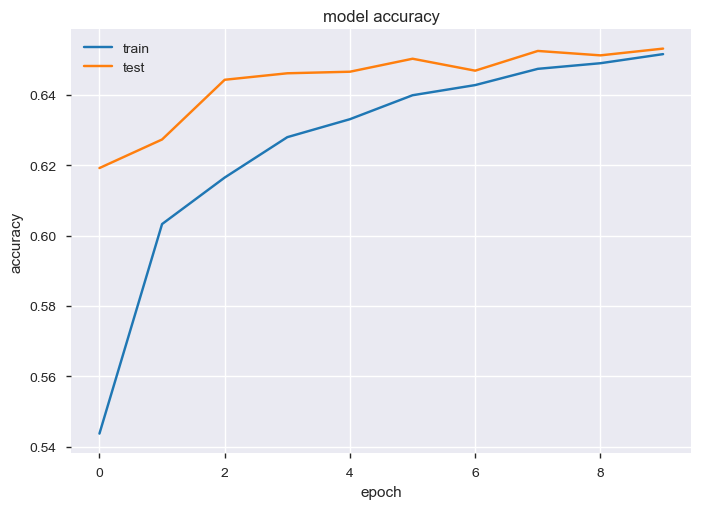

In [160]:
# summarize history for Accuracy
#fig_acc = plt.figure(figsize=(5, 5))
plt.plot(history.history['acc']);
plt.plot(history.history['val_acc']);
plt.title('model accuracy');
plt.ylabel('accuracy');
plt.xlabel('epoch');
plt.legend(['train', 'test'], loc='upper left');
plt.show();

__NOTE__: May be able to improve the result with more epochs. 

In [ ]:
# Load in model and evaluate on validation data
# model = load_model('rnn_glove_model.h5')
# model.evaluate(X_dev, Y_dev)

In [161]:
# INFERENCE: score on test set
score, acc = model.evaluate(X_dev, Y_dev, verbose = 0)
# print("Score on dev set: %.2f" % (score))
print("Accuracy on dev set: %.4f" % (acc))

Accuracy on dev set: 0.6556


In [162]:
# Predictions
pred_dev_proba = model.predict(X_dev) # probabilities
pred_dev = model.predict_classes(X_dev) # classes with highest prob

# Actual
true_dev = [np.argmax(x) for x in Y_dev]

# Find accuracies
accuracy = accuracy_score(true_dev, pred_dev)

In [163]:
# cosnistency check
print("Accuracy on dev set: %.4f" % (accuracy))

Accuracy on dev set: 0.6556


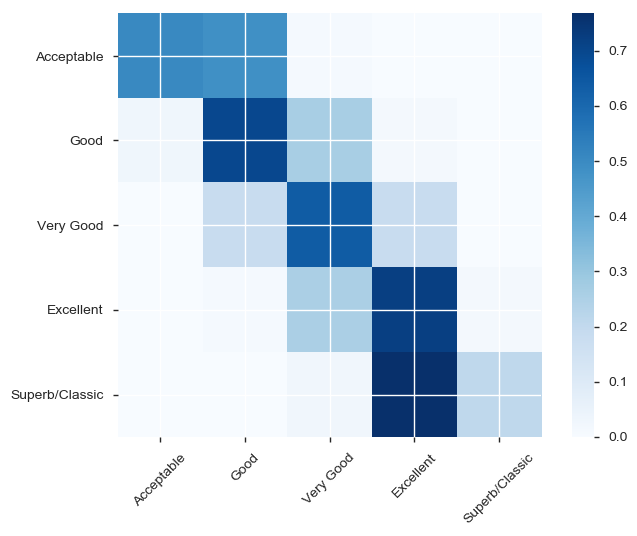

In [164]:
# get confusion matrix
cm = confusion_matrix(true_dev, pred_dev)
# normalize confusion matrix
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# plot confusion matrix
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
class_name = ["Acceptable", "Good", "Very Good", "Excellent", "Superb/Classic"]
plt.colorbar()
tick_marks = np.arange(len(class_name))
plt.xticks(tick_marks, class_name, rotation=45)
plt.yticks(tick_marks, class_name)
plt.show()

Check out [stackoverflow](https://stackoverflow.com/questions/20927368/python-how-to-normalize-a-confusion-matrix) for discussion on how to normalize confusion matrix (CM).

In [166]:
# without normalization
confusion_matrix(true_dev, pred_dev)

array([[ 519,  497,   10,    0,    0],
       [ 256, 6247, 2345,  124,    0],
       [   2, 2150, 7511, 2132,    0],
       [   0,  116, 2700, 7619,  132],
       [   0,    0,   37, 1171,  318]])

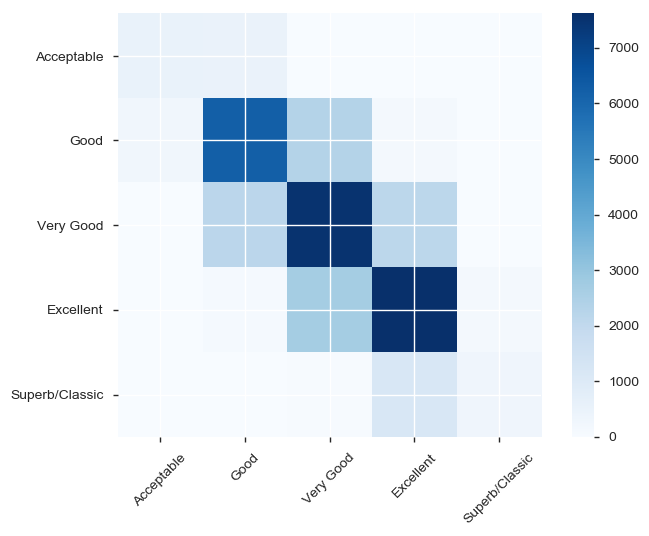

In [167]:
# plot without normalization

# get confusion matrix
cm = confusion_matrix(true_dev, pred_dev)

# plot confusion matrix
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
class_name = ["Acceptable", "Good", "Very Good", "Excellent", "Superb/Classic"]
plt.colorbar()
tick_marks = np.arange(len(class_name))
plt.xticks(tick_marks, class_name, rotation=45)
plt.yticks(tick_marks, class_name)
plt.show()

## BI-DIRECTIONAL RNN Model with Pre-Trained Embedding

In [ ]:
# Example from Keras Docs: https://keras.io/layers/wrappers/
# model = Sequential()
# model.add(Bidirectional(LSTM(10, return_sequences=True), input_shape=(5, 10)))
# model.add(Bidirectional(LSTM(10)))
# model.add(Dense(5))
# model.add(Activation('softmax'))
# model.compile(loss='categorical_crossentropy', optimizer='rmsprop')

In [138]:
# Here we use an alternative approach to define a Keras model w/o the Sequential API

# embedding layer
embedding_layer = Embedding(input_dim=max_features,
                            input_length = maxlen,
                            output_dim=embedding_size,
                            weights=[embedding_matrix],
                            trainable=False) 
# input into embedding layer
input= Input(shape=(maxlen, ), 
             dtype = 'int32')
embedded_sequences = embedding_layer(input) 
# Bidirectional RNN
x = Bidirectional(LSTM(lstm_out, 
                       return_sequences=True))(embedded_sequences)
# Max pooling
x = GlobalMaxPooling1D()(x)
# fully connected
x = Dense(number_dense, activation = 'relu')(x)
# dropout for regularization
x = Dropout(0.5)(x)
# final layer
output = Dense(number_out, activation='softmax')(x)
# define and compile the model 
model = Model(inputs=input, outputs=output)
model.compile(loss="categorical_crossentropy", 
              optimizer='adam', 
              metrics=['accuracy'])
# print model
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 50)                0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 50, 300)           3000000   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 50, 200)           320800    
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 200)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 50)                10050     
_________________________________________________________________
dropout_2 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 5)                 255       
Total para

In [139]:
# TRAINING
batch_size = 32
epochs = 10 

# Create callbacks
callbacks = [EarlyStopping(monitor='val_loss', patience=3),
             ModelCheckpoint('bi-rnn_glove_model.h5', save_best_only=True, save_weights_only=False)]

history = model.fit(X_train, Y_train, epochs = epochs, 
                    batch_size=batch_size, 
                    # validation_split=0.1,
                    validation_data=(X_dev, Y_dev),
                    verbose = 1,
                    callbacks = callbacks)

Train on 135544 samples, validate on 33886 samples
Epoch 1/10
135544/135544 [==============================] - 323s 2ms/step - loss: 0.9326 - acc: 0.5860 - val_loss: 0.8081 - val_acc: 0.6361
Epoch 2/10
135544/135544 [==============================] - 316s 2ms/step - loss: 0.8244 - acc: 0.6349 - val_loss: 0.7741 - val_acc: 0.6533
Epoch 3/10
135544/135544 [==============================] - 315s 2ms/step - loss: 0.7835 - acc: 0.6518 - val_loss: 0.7601 - val_acc: 0.6606
Epoch 4/10
135544/135544 [==============================] - 314s 2ms/step - loss: 0.7499 - acc: 0.6668 - val_loss: 0.7612 - val_acc: 0.6624
Epoch 5/10
135544/135544 [==============================] - 304s 2ms/step - loss: 0.7234 - acc: 0.6760 - val_loss: 0.7708 - val_acc: 0.6591
Epoch 6/10
135544/135544 [==============================] - 312s 2ms/step - loss: 0.6950 - acc: 0.6890 - val_loss: 0.7936 - val_acc: 0.6519


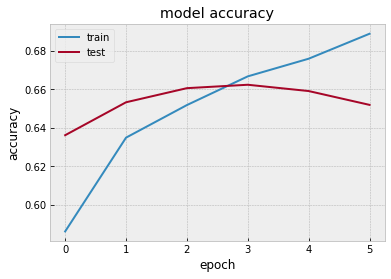

In [140]:
# summarize history for Accuracy
#fig_acc = plt.figure(figsize=(5, 5))
plt.plot(history.history['acc']);
plt.plot(history.history['val_acc']);
plt.title('model accuracy');
plt.ylabel('accuracy');
plt.xlabel('epoch');
plt.legend(['train', 'test'], loc='upper left');
plt.show();

In [141]:
# INFERENCE: score on test set
score, acc = model.evaluate(X_dev, Y_dev, verbose = 0)
# print("Score on dev set: %.2f" % (score))
print("Accuracy on dev set: %.4f" % (acc))

Accuracy on dev set: 0.6519


In [143]:
# Load in best model and evaluate on validation data
from keras.models import load_model

model = load_model('bi-rnn_glove_model.h5')

# INFERENCE: score on test set
score, acc = model.evaluate(X_dev, Y_dev, verbose = 0)
# print("Score on dev set: %.2f" % (score))
print("Accuracy on dev set: %.4f" % (acc))

Accuracy on dev set: 0.6606


__NOTE__:
- The ```predict_classes``` method is only available for the Sequential class (which is the class of our previous model) but not for the ```Model``` class (the class of the current, bi-directional model).
- With the ```Model``` class, you can use the ```predict``` method which will give you a vector of probabilities and then get the ```argmax``` of this vector (with ```np.argmax(y_pred1,axis=1)```).    

In [146]:
# Predictions
pred_dev_proba = model.predict(X_dev) # probabilities
pred_dev = np.argmax(pred_dev_proba, axis=1) # classes with highest prob

# Actual
true_dev = [np.argmax(x) for x in Y_dev]

# Find accuracies
accuracy = accuracy_score(true_dev, pred_dev)

In [147]:
# cosnistency check
print("Accuracy on dev set: %.4f" % (accuracy))

Accuracy on dev set: 0.6606


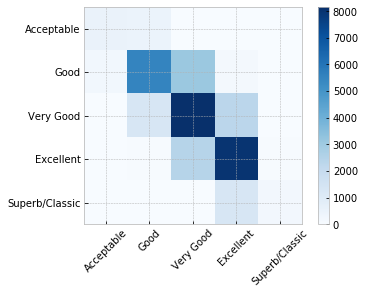

In [148]:
# plot confusion matrix CM without normalization

# get confusion matrix
cm = confusion_matrix(true_dev, pred_dev)

# plot confusion matrix
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
class_name = ["Acceptable", "Good", "Very Good", "Excellent", "Superb/Classic"]
plt.colorbar()
tick_marks = np.arange(len(class_name))
plt.xticks(tick_marks, class_name, rotation=45)
plt.yticks(tick_marks, class_name)
plt.show()

In [149]:
cm

array([[ 514,  496,   16,    0,    0],
       [ 244, 5490, 3099,  139,    0],
       [   2, 1310, 8164, 2319,    0],
       [   0,   47, 2449, 8011,   60],
       [   0,    0,   29, 1290,  207]])

## MODEL ARCHITECTURE WITH PRE-TRAINED EMBEDDING: Function

To make our code more reproducible, in this section we pack the RNN definition into a function, with various parameters to detail the architecture. 

In [169]:
# function to build and compile RNN model
def make_rnn_model(num_words,
                   embedding_matrix,
                   lstm_layers=1,
                   lstm_cells=100,
                   number_dense=50,
                   number_out=5,
                   trainable=False,
                   bi_direc=False,
                   max_pool=False,
                   dropout=0.3):
    """
    Make a word-level recurrent neural network with option for pretrained embeddings
    and varying numbers of LSTM cell layers.
    """
    
    # use Keras Sequential class
    model = Sequential()

    # Map words to an embedding
    if not trainable:
        model.add(Embedding(input_dim=num_words,
                            output_dim=embedding_matrix.shape[1],
                            weights=[embedding_matrix],
                            trainable=False,
                            mask_zero=True))
        model.add(Masking(mask_value=0.0))
    else:
        model.add(Embedding(input_dim=num_words,
                            output_dim=embedding_matrix.shape[1],
                            weights=[embedding_matrix],
                            trainable=True))

    # Add multiple LSTM layers if desired (going DEEP)
    if lstm_layers > 1:
        for i in range(lstm_layers - 1):
            if bi_direc:
                model.add(Bidirectional(LSTM(lstm_cells, return_sequences=True,
                                             dropout=dropout, recurrent_dropout=dropout)))
            else:
                model.add(LSTM(lstm_cells, return_sequences=True,
                       dropout=dropout, recurrent_dropout=dropout))

    # Add final LSTM layer
    if bi_direc:
        model.add(Bidirectional(LSTM(lstm_cells, return_sequences=False,
                                     dropout=dropout, recurrent_dropout=dropout)))
    else:
        model.add(LSTM(lstm_cells, return_sequences=False,
                       dropout=dropout, recurrent_dropout=dropout))
    # Fully connected layer
    model.add(Dense(number_dense, activation='relu'))
    # Dropout for regularization
    model.add(Dropout(0.5))
    # Output layer
    model.add(Dense(number_out, activation='softmax'))

    # Compile the model
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model

In [172]:
# function to define callbacks
def make_callbacks(model_name, save=True):
    """Make list of callbacks for training"""
    
    callbacks = [EarlyStopping(monitor='val_loss', patience=3)]

    if save:
        callbacks.append(ModelCheckpoint(model_name+'.h5',
                                         save_best_only=True,
                                         save_weights_only=False))
    return callbacks

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_18 (Embedding)     (None, None, 300)         3000000   
_________________________________________________________________
masking_17 (Masking)         (None, None, 300)         0         
_________________________________________________________________
bidirectional_18 (Bidirectio (None, 200)               320800    
_________________________________________________________________
dense_29 (Dense)             (None, 50)                10050     
_________________________________________________________________
dropout_15 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_30 (Dense)             (None, 5)                 255       
Total params: 3,331,105
Trainable params: 331,105
Non-trainable params: 3,000,000
____________________________________________________________

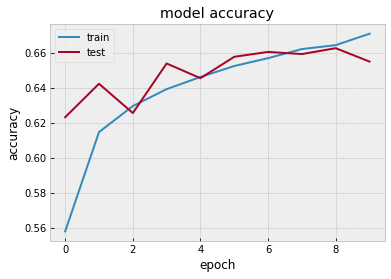

Starting INFERENCE...
Accuracy on dev set: 0.6594


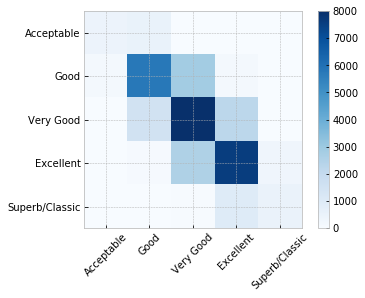

In [175]:
# MODEL and TRAINING DEFINITION
model_name ='bi-rnn_glove_model_f1'
layers=1
batch_size = 32
epochs = 10


# MODEL COMPILATION
model = make_rnn_model(num_words=max_features,
                       embedding_matrix=embedding_matrix,
                       bi_direc=True, lstm_layers=layers)
print(model.summary())


# TRAINING
print('Starting TRAINING...')
callbacks = make_callbacks(model_name)

history = model.fit(X_train, Y_train, epochs = epochs, 
                    batch_size=batch_size, 
                    # validation_split=0.1,
                    validation_data=(X_dev, Y_dev),
                    verbose = 1,
                    callbacks = callbacks)

# PLOT training history
plt.plot(history.history['acc']);
plt.plot(history.history['val_acc']);
plt.title('model accuracy');
plt.ylabel('accuracy');
plt.xlabel('epoch');
plt.legend(['train', 'test'], loc='upper left');
plt.show();


# INFERENCE
print('Starting INFERENCE...')
# load best model
model = load_model(model_name+'.h5')

# print accuracy on dev set
score, acc = model.evaluate(X_dev, Y_dev, verbose = 0)
print("Accuracy on dev set: %.4f" % (acc))

# Predictions on dev set
pred_dev_proba = model.predict(X_dev) # probabilities
pred_dev = model.predict_classes(X_dev) # classes with highest prob
# Actual
true_dev = [np.argmax(x) for x in Y_dev]

# PLOT confusion matrix CM without normalization
cm = confusion_matrix(true_dev, pred_dev)
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
class_name = ["Acceptable", "Good", "Very Good", "Excellent", "Superb/Classic"]
plt.colorbar()
tick_marks = np.arange(len(class_name))
plt.xticks(tick_marks, class_name, rotation=45)
plt.yticks(tick_marks, class_name)
plt.show()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_21 (Embedding)     (None, None, 300)         3000000   
_________________________________________________________________
masking_20 (Masking)         (None, None, 300)         0         
_________________________________________________________________
bidirectional_23 (Bidirectio (None, None, 200)         320800    
_________________________________________________________________
bidirectional_24 (Bidirectio (None, 200)               240800    
_________________________________________________________________
dense_35 (Dense)             (None, 50)                10050     
_________________________________________________________________
dropout_18 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_36 (Dense)             (None, 5)                 255       
Total para

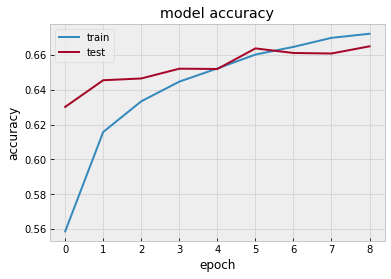

Starting INFERENCE...
Accuracy on dev set: 0.6639


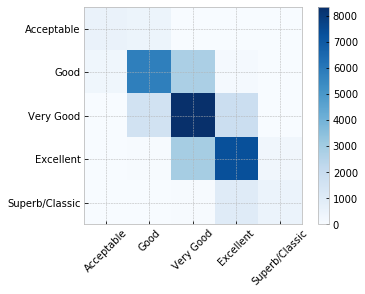

In [178]:
# MODEL and TRAINING DEFINITION
model_name ='bi-rnn_glove_model_f2'
layers=2
batch_size = 32
epochs = 10


# MODEL COMPILATION
model = make_rnn_model(num_words=max_features,
                       embedding_matrix=embedding_matrix,
                       bi_direc=True, lstm_layers=layers)
print(model.summary())


# TRAINING
print('Starting TRAINING...')
callbacks = make_callbacks(model_name)

history = model.fit(X_train, Y_train, epochs = epochs, 
                    batch_size=batch_size, 
                    # validation_split=0.1,
                    validation_data=(X_dev, Y_dev),
                    verbose = 1,
                    callbacks = callbacks)

# PLOT training history
plt.plot(history.history['acc']);
plt.plot(history.history['val_acc']);
plt.title('model accuracy');
plt.ylabel('accuracy');
plt.xlabel('epoch');
plt.legend(['train', 'test'], loc='upper left');
plt.show();


# INFERENCE
print('Starting INFERENCE...')
# load best model
model = load_model(model_name+'.h5')

# print accuracy on dev set
score, acc = model.evaluate(X_dev, Y_dev, verbose = 0)
print("Accuracy on dev set: %.4f" % (acc))

# Predictions on dev set
pred_dev_proba = model.predict(X_dev) # probabilities
pred_dev = model.predict_classes(X_dev) # classes with highest prob
# Actual
true_dev = [np.argmax(x) for x in Y_dev]

# PLOT confusion matrix CM without normalization
cm = confusion_matrix(true_dev, pred_dev)
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
class_name = ["Acceptable", "Good", "Very Good", "Excellent", "Superb/Classic"]
plt.colorbar()
tick_marks = np.arange(len(class_name))
plt.xticks(tick_marks, class_name, rotation=45)
plt.yticks(tick_marks, class_name)
plt.show()

In [179]:
cm

array([[ 554,  454,   18,    0,    0],
       [ 309, 5776, 2783,  103,    1],
       [   1, 1573, 8345, 1873,    3],
       [   0,   61, 2911, 7319,  276],
       [   0,    0,   36,  988,  502]])

### Bi-directional RNN with loaded utility functions

In [43]:
# use pre-loaded data
cols_target = ['rating_0', 'rating_1', 'rating_2', 'rating_3', 'rating_4']
Y_train = model_data_train[cols_target]
X_train = model_data_train.drop(columns=cols_target, axis=1)
Y_dev = model_data_dev[cols_target]
X_dev = model_data_dev.drop(columns=cols_target, axis=1)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, None, 300)         3000000   
_________________________________________________________________
masking_4 (Masking)          (None, None, 300)         0         
_________________________________________________________________
bidirectional_4 (Bidirection (None, 300)               541200    
_________________________________________________________________
dense_7 (Dense)              (None, 100)               30100     
_________________________________________________________________
dropout_4 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 5)                 505       
Total params: 3,571,805
Trainable params: 571,805
Non-trainable params: 3,000,000
____________________________________________________________

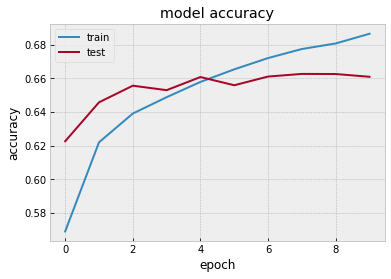

Starting INFERENCE...


NameError: name 'load_model' is not defined

In [55]:
# MODEL and TRAINING DEFINITION
model_name ='bi-rnn_glove_model_f3'
layers=1
lstm_cells=150
number_dense=100
batch_size = 32
epochs = 10
max_features = max_words


# MODEL COMPILATION
model = util.make_rnn_model(num_words=max_features,
                            embedding_matrix=embedding_matrix,
                            lstm_cells=lstm_cells,
                            number_dense=number_dense,
                            bi_direc=True, lstm_layers=layers)
print(model.summary())


# TRAINING
print('Starting TRAINING...')
callbacks = util.make_callbacks(model_name)

history = model.fit(X_train, Y_train, epochs = epochs, 
                    batch_size=batch_size, 
                    # validation_split=0.1,
                    validation_data=(X_dev, Y_dev),
                    verbose = 1,
                    callbacks = callbacks)

# PLOT training history
plt.plot(history.history['acc']);
plt.plot(history.history['val_acc']);
plt.title('model accuracy');
plt.ylabel('accuracy');
plt.xlabel('epoch');
plt.legend(['train', 'test'], loc='upper left');
plt.show();


# INFERENCE
print('Starting INFERENCE...')
# load best model
model = load_model(model_name+'.h5')

# print accuracy on dev set
score, acc = model.evaluate(X_dev, Y_dev, verbose = 0)
print("Accuracy on dev set: %.4f" % (acc))

# Predictions on dev set
pred_dev_proba = model.predict(X_dev) # probabilities
pred_dev = model.predict_classes(X_dev) # classes with highest prob
# Actual
true_dev = [np.argmax(x) for x in Y_dev]

# PLOT confusion matrix CM without normalization
cm = confusion_matrix(true_dev, pred_dev)
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
class_name = ["Acceptable", "Good", "Very Good", "Excellent", "Superb/Classic"]
plt.colorbar()
tick_marks = np.arange(len(class_name))
plt.xticks(tick_marks, class_name, rotation=45)
plt.yticks(tick_marks, class_name)
plt.show()

Starting INFERENCE...
Accuracy on dev set: 0.6610


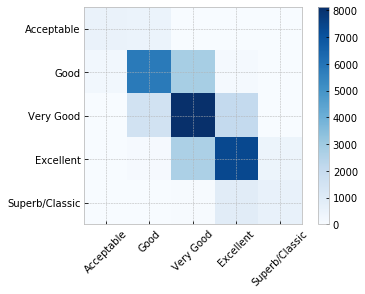

In [73]:
# INFERENCE
print('Starting INFERENCE...')
# load best model
model = load_model(model_name+'.h5')

# print accuracy on dev set
score, acc = model.evaluate(X_dev, Y_dev, verbose = 0)
print("Accuracy on dev set: %.4f" % (acc))

# Predictions on dev set
pred_dev_proba = model.predict(X_dev) # probabilities
pred_dev = model.predict_classes(X_dev) # classes with highest prob
# Actual
# true_dev = [np.argmax(x) for x in Y_dev.values]
true_dev = data_dev_simple['rating']

# PLOT confusion matrix CM without normalization
cm = confusion_matrix(true_dev, pred_dev)
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
class_name = ["Acceptable", "Good", "Very Good", "Excellent", "Superb/Classic"]
plt.colorbar()
tick_marks = np.arange(len(class_name))
plt.xticks(tick_marks, class_name, rotation=45)
plt.yticks(tick_marks, class_name)
plt.show()

In [74]:
cm

array([[ 514,  497,   15,    0,    0],
       [ 250, 5791, 2804,  127,    0],
       [   1, 1561, 8134, 2090,    9],
       [   0,   80, 2699, 7368,  420],
       [   0,    0,   38,  895,  593]])

## MODEL ARCITECTURE WITH ATTENTION

Interesting Blog posts on implementations of Attention mechanisms: 
- [What Kagglers are using for Text Classification](https://mlwhiz.com/blog/2018/12/17/text_classification/)
- [Attention, CNN and what not for Text Classification](https://towardsdatascience.com/nlp-learning-series-part-3-attention-cnn-and-what-not-for-text-classification-4313930ed566)
- [Sentiment Analysis using Deep Learning techniques with India Elections 2019](https://towardsdatascience.com/sentiment-analysis-using-deep-learning-techniques-with-india-elections-2019-a-case-study-451549c8eb46)

In [112]:
from keras.engine.topology import Layer, InputSpec
from keras import initializers, constraints

#Refr: https://github.com/richliao/textClassifier/issues/28
#Refr: https://gist.github.com/cbaziotis/7ef97ccf71cbc14366835198c09809d2
#Refr: https://gist.github.com/nigeljyng/37552fb4869a5e81338f82b338a304d3
class AttLayer(Layer):
    def __init__(self, attention_dim):
        self.init = initializers.get('normal')
        self.supports_masking = True
        self.attention_dim = attention_dim
        super(AttLayer, self).__init__()

    def build(self, input_shape):
        assert len(input_shape) == 3
        self.W = K.variable(self.init((input_shape[-1], self.attention_dim)))
        self.b = K.variable(self.init((self.attention_dim, )))
        self.u = K.variable(self.init((self.attention_dim, 1)))
        self.trainable_weights = [self.W, self.b, self.u]
        super(AttLayer, self).build(input_shape)

    def compute_mask(self, inputs, mask=None):
        return mask

    def call(self, x, mask=None):
        # size of x :[batch_size, sel_len, attention_dim]
        # size of u :[batch_size, attention_dim]
        # uit = tanh(xW+b)
        uit = K.tanh(K.bias_add(K.dot(x, self.W), self.b))
        ait = K.dot(uit, self.u)
        ait = K.squeeze(ait, -1)

        ait = K.exp(ait)

        if mask is not None:
            # Cast the mask to floatX to avoid float64 upcasting in theano
            ait *= K.cast(mask, K.floatx())
        ait /= K.cast(K.sum(ait, axis=1, keepdims=True) + K.epsilon(), K.floatx())
        ait = K.expand_dims(ait)
        weighted_input = x * ait
        output = K.sum(weighted_input, axis=1)

        return output

    def compute_output_shape(self, input_shape):
        return (input_shape[0], input_shape[-1])

In [109]:
#fileName classifygloveattlstm.py at https://github.com/sharmi1206/elections-2019
EMBEDDING_DIM = 300
MAX_SEQUENCE_LENGTH = 50
NO_CLASSES = 5
dropout = 0.5

# embedding layer
embedding_layer = Embedding(input_dim=max_features,
                            input_length = MAX_SEQUENCE_LENGTH,
                            output_dim=embedding_matrix.shape[1],
                            weights=[embedding_matrix],
                            trainable=False) 
# input into embedding layer
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH, ), 
                       dtype = 'int32')
embedded_sequences = embedding_layer(sequence_input) 
l_gru = Bidirectional(GRU(100, return_sequences=True,
                          dropout=dropout, recurrent_dropout=dropout))(embedded_sequences)

#Refr:https://github.com/richliao/textClassifier/issues/28
l_att = AttLayer(64)(l_gru)
# fully connected
preds = Dense(NO_CLASSES, activation='softmax')(l_att)

model = Model(sequence_input, preds)
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['acc'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 50)                0         
_________________________________________________________________
embedding_14 (Embedding)     (None, 50, 300)           3000000   
_________________________________________________________________
bidirectional_11 (Bidirectio (None, 50, 200)           240600    
_________________________________________________________________
att_layer_5 (AttLayer)       (None, 200)               12928     
_________________________________________________________________
dense_13 (Dense)             (None, 5)                 1005      
Total params: 3,254,533
Trainable params: 254,533
Non-trainable params: 3,000,000
_________________________________________________________________


Starting TRAINING...
Train on 135544 samples, validate on 33886 samples
Epoch 1/10
135544/135544 [==============================] - 319s 2ms/step - loss: 0.9322 - acc: 0.5800 - val_loss: 0.8167 - val_acc: 0.6324
Epoch 2/10
135544/135544 [==============================] - 314s 2ms/step - loss: 0.8458 - acc: 0.6201 - val_loss: 0.7900 - val_acc: 0.6467
Epoch 3/10
135544/135544 [==============================] - 296s 2ms/step - loss: 0.8215 - acc: 0.6309 - val_loss: 0.7790 - val_acc: 0.6500
Epoch 4/10
135544/135544 [==============================] - 284s 2ms/step - loss: 0.8073 - acc: 0.6398 - val_loss: 0.7747 - val_acc: 0.6500
Epoch 5/10
135544/135544 [==============================] - 272s 2ms/step - loss: 0.7987 - acc: 0.6421 - val_loss: 0.7699 - val_acc: 0.6545
Epoch 6/10
135544/135544 [==============================] - 284s 2ms/step - loss: 0.7918 - acc: 0.6459 - val_loss: 0.7645 - val_acc: 0.6566
Epoch 7/10
135544/135544 [==============================] - 297s 2ms/step - loss: 0.7863

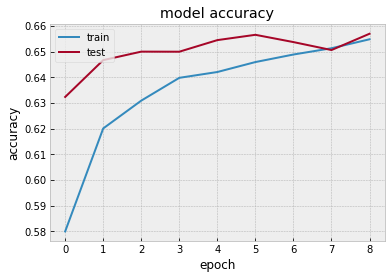

Starting INFERENCE...
Accuracy on dev set: 0.6570


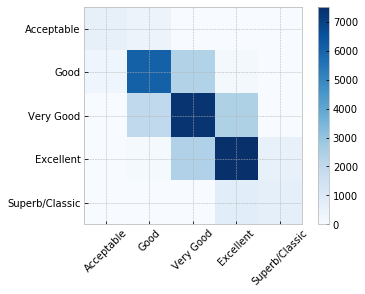

In [110]:
# TRAINING
model_name ='bi-rnn_glove_model_att_f1'

print('Starting TRAINING...')
callbacks = util.make_callbacks(model_name)

history = model.fit(X_train, Y_train, epochs = epochs, 
                    batch_size=batch_size, 
                    # validation_split=0.1,
                    validation_data=(X_dev, Y_dev),
                    verbose = 1,
                    callbacks = callbacks)

# PLOT training history
plt.plot(history.history['acc']);
plt.plot(history.history['val_acc']);
plt.title('model accuracy');
plt.ylabel('accuracy');
plt.xlabel('epoch');
plt.legend(['train', 'test'], loc='upper left');
plt.show();

# INFERENCE
print('Starting INFERENCE...')
# load best model
# model = load_model(model_name+'.h5')

# print accuracy on dev set
score, acc = model.evaluate(X_dev, Y_dev, verbose = 0)
print("Accuracy on dev set: %.4f" % (acc))

# Predictions
pred_dev_proba = model.predict(X_dev) # probabilities
pred_dev = np.argmax(pred_dev_proba, axis=1) # classes with highest prob

# Actual
# true_dev = [np.argmax(x) for x in Y_dev.values]
true_dev = data_dev_simple['rating']

# PLOT confusion matrix CM without normalization
cm = confusion_matrix(true_dev, pred_dev)
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
class_name = ["Acceptable", "Good", "Very Good", "Excellent", "Superb/Classic"]
plt.colorbar()
tick_marks = np.arange(len(class_name))
plt.xticks(tick_marks, class_name, rotation=45)
plt.yticks(tick_marks, class_name)
plt.show()

In [111]:
cm

array([[ 593,  419,   14,    0,    0],
       [ 346, 6101, 2369,  156,    0],
       [   4, 1987, 7351, 2438,   15],
       [   0,   98, 2380, 7521,  568],
       [   0,    1,   28,  801,  696]])

## MODEL ARCITECTURE WITH ATTENTION II

In [121]:
def dot_product(x, kernel):
    """
    Wrapper for dot product operation, in order to be compatible with both
    Theano and Tensorflow
    Args:
        x (): input
        kernel (): weights
    Returns:
    """
    if K.backend() == 'tensorflow':
        return K.squeeze(K.dot(x, K.expand_dims(kernel)), axis=-1)
    else:
        return K.dot(x, kernel)

In [122]:
from keras.engine.topology import Layer, InputSpec
from keras import initializers, constraints

class AttentionWithContext(Layer):
    """
    Attention operation, with a context/query vector, for temporal data.
    Supports Masking.
    Follows the work of Yang et al. [https://www.cs.cmu.edu/~diyiy/docs/naacl16.pdf]
    "Hierarchical Attention Networks for Document Classification"
    by using a context vector to assist the attention
    # Input shape
        3D tensor with shape: (samples, steps, features).
    # Output shape
        2D tensor with shape: (samples, features).
    How to use:
    Just put it on top of an RNN Layer (GRU/LSTM/SimpleRNN) with return_sequences=True.
    The dimensions are inferred based on the output shape of the RNN.
    Note: The layer has been tested with Keras 2.0.6
    Example:
        model.add(LSTM(64, return_sequences=True))
        model.add(AttentionWithContext())
        # next add a Dense layer (for classification/regression) or whatever...
    """

    def __init__(self,
                 W_regularizer=None, u_regularizer=None, b_regularizer=None,
                 W_constraint=None, u_constraint=None, b_constraint=None,
                 bias=True, **kwargs):

        self.supports_masking = True
        self.init = initializers.get('glorot_uniform')

        self.W_regularizer = regularizers.get(W_regularizer)
        self.u_regularizer = regularizers.get(u_regularizer)
        self.b_regularizer = regularizers.get(b_regularizer)

        self.W_constraint = constraints.get(W_constraint)
        self.u_constraint = constraints.get(u_constraint)
        self.b_constraint = constraints.get(b_constraint)

        self.bias = bias
        super(AttentionWithContext, self).__init__(**kwargs)

    def build(self, input_shape):
        assert len(input_shape) == 3

        self.W = self.add_weight((input_shape[-1], input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_W'.format(self.name),
                                 regularizer=self.W_regularizer,
                                 constraint=self.W_constraint)
        if self.bias:
            self.b = self.add_weight((input_shape[-1],),
                                     initializer='zero',
                                     name='{}_b'.format(self.name),
                                     regularizer=self.b_regularizer,
                                     constraint=self.b_constraint)

        self.u = self.add_weight((input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_u'.format(self.name),
                                 regularizer=self.u_regularizer,
                                 constraint=self.u_constraint)

        super(AttentionWithContext, self).build(input_shape)

    def compute_mask(self, input, input_mask=None):
        # do not pass the mask to the next layers
        return None

    def call(self, x, mask=None):
        uit = dot_product(x, self.W)

        if self.bias:
            uit += self.b

        uit = K.tanh(uit)
        ait = dot_product(uit, self.u)

        a = K.exp(ait)

        # apply mask after the exp. will be re-normalized next
        if mask is not None:
            # Cast the mask to floatX to avoid float64 upcasting in theano
            a *= K.cast(mask, K.floatx())

        # in some cases especially in the early stages of training the sum may be almost zero
        # and this results in NaN's. A workaround is to add a very small positive number ε to the sum.
        # a /= K.cast(K.sum(a, axis=1, keepdims=True), K.floatx())
        a /= K.cast(K.sum(a, axis=1, keepdims=True) + K.epsilon(), K.floatx())

        a = K.expand_dims(a)
        weighted_input = x * a
        return K.sum(weighted_input, axis=1)

    def compute_output_shape(self, input_shape):
        return input_shape[0], input_shape[-1]

In [123]:
def model_lstm_atten(embedding_matrix, max_features=10000, embed_size=300, maxlen=50):
    """
    function to build and reurn compuiled bi-directional RNN model with attention
    """
    
    # input layer
    inp = Input(shape=(maxlen,), dtype = 'int32')
    # run input through embedding
    x = Embedding(max_features, embed_size, weights=[embedding_matrix], trainable=False)(inp)
    # bi-directional LSTM
    x = Bidirectional(LSTM(128, return_sequences=True))(x)
    x = Bidirectional(LSTM(64, return_sequences=True))(x)
    x = AttentionWithContext()(x)
    # dense FNN
    x = Dense(64, activation="relu")(x)
    # dropput for regularization
    x = Dropout(0.5)(x)
    x = Dense(5, activation="softmax")(x)
    # define full model outputs=Model(inputs)
    model = Model(inputs=inp, outputs=x)
    # compile model
    model.compile(loss='categorical_crossentropy', 
                  optimizer='adam', 
                  metrics=['accuracy'])
    # print model summary
    print(model.summary())
    
    return model

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 50)                0         
_________________________________________________________________
embedding_16 (Embedding)     (None, 50, 300)           3000000   
_________________________________________________________________
bidirectional_14 (Bidirectio (None, 50, 256)           439296    
_________________________________________________________________
bidirectional_15 (Bidirectio (None, 50, 128)           164352    
_________________________________________________________________
attention_with_context_1 (At (None, 128)               16640     
_________________________________________________________________
dense_14 (Dense)             (None, 64)                8256      
_________________________________________________________________
dropout_6 (Dropout)          (None, 64)                0         
__________

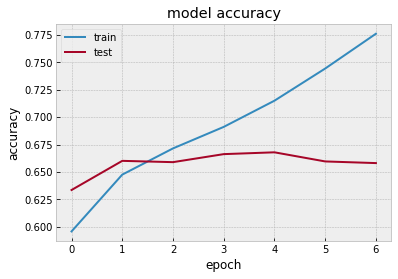

Starting INFERENCE...
Accuracy on dev set: 0.6581


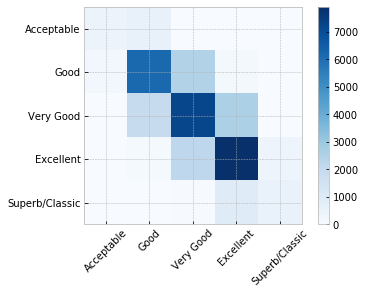

In [124]:
# MODEL COMPILATION
model = model_lstm_atten(embedding_matrix=embedding_matrix)

# TRAINING
model_name ='bi-rnn_glove_model_att_f2'

print('Starting TRAINING...')
callbacks = util.make_callbacks(model_name)

history = model.fit(X_train, Y_train, epochs = epochs, 
                    batch_size=batch_size, 
                    # validation_split=0.1,
                    validation_data=(X_dev, Y_dev),
                    verbose = 1,
                    callbacks = callbacks)

# PLOT training history
plt.plot(history.history['acc']);
plt.plot(history.history['val_acc']);
plt.title('model accuracy');
plt.ylabel('accuracy');
plt.xlabel('epoch');
plt.legend(['train', 'test'], loc='upper left');
plt.show();

# INFERENCE
print('Starting INFERENCE...')
# load best model
# model = load_model(model_name+'.h5')

# print accuracy on dev set
score, acc = model.evaluate(X_dev, Y_dev, verbose = 0)
print("Accuracy on dev set: %.4f" % (acc))

# Predictions
pred_dev_proba = model.predict(X_dev) # probabilities
pred_dev = np.argmax(pred_dev_proba, axis=1) # classes with highest prob

# Actual
# true_dev = [np.argmax(x) for x in Y_dev.values]
true_dev = data_dev_simple['rating']

# PLOT confusion matrix CM without normalization
cm = confusion_matrix(true_dev, pred_dev)
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
class_name = ["Acceptable", "Good", "Very Good", "Excellent", "Superb/Classic"]
plt.colorbar()
tick_marks = np.arange(len(class_name))
plt.xticks(tick_marks, class_name, rotation=45)
plt.yticks(tick_marks, class_name)
plt.show()

In [125]:
cm

array([[ 439,  571,   14,    2,    0],
       [ 190, 6175, 2447,  155,    5],
       [   0, 1946, 7228, 2606,   15],
       [   0,  106, 2176, 7912,  373],
       [   0,    0,   34,  946,  546]])

## PROBLEM: Load Model with Customized Attention Layer

Under construction. Read [here](https://github.com/keras-team/keras/issues/4871) for potential fix.

In [134]:
print(model_name)

bi-rnn_glove_model_att_f2


In [135]:
load_model(model_name+'.h5')

ValueError: Unknown layer: AttentionWithContext

In [141]:
### SAVE WITH PICKLE
filename = 'bi-rnn_glove_model_att_f2.pickle'
file = open(filename, 'wb')
pickle.dump(model, file)

In [142]:
### LOAD WITH PICKLE
loaded_pickle_model = pickle.load(open(filename, 'rb'))

ValueError: Unknown layer: AttentionWithContext

In [143]:
### SAVE WITH JOBLIB
filename = 'bi-rnn_glove_model_att_f2.joblib'
joblib.dump(model, filename)

['bi-rnn_glove_model_att_f2.joblib']

In [144]:
### LOAD WITH JOBLIB
loaded_joblib_model = joblib.load(filename)

ValueError: Unknown layer: AttentionWithContext

# TRANSFER LEARNING

Under construction. Interesting [read](https://towardsdatascience.com/nlp-learning-series-part-4-transfer-learning-intuition-for-text-classification-4eb90495c19f).

<a id='stacking'></a>

# MODEL STACKING

- In this section we apply a strategy called _model stacking_. Specifically, we use the probability predictions of our RNN as engineered features for a simple classifier, together with other original features such as price or country. 
- This is done for pedagodical reasons only; further model improvements using HPO and model blending will be left for future work. 

In [146]:
# load one of our RNN models and store predictions as features in DataFrame
model_name = 'bi-rnn_glove_model_f2'
model_loaded = load_model(model_name+'.h5')

# print accuracy on dev set
score, acc = model_loaded.evaluate(X_dev, Y_dev, verbose = 0)
print("Accuracy on dev set: %.4f" % (acc))

Accuracy on dev set: 0.6639


In [148]:
# Predictions
pred_train_proba = model_loaded.predict(X_train) # probabilities
pred_dev_proba = model_loaded.predict(X_dev) # probabilities

col_names = ['prob_0', 'prob_1', 'prob_2', 'prob_3', 'prob_4']
features_prob_train = pd.DataFrame(data=pred_train_proba, index=X_train.index, 
                                   columns=col_names)
features_prob_dev = pd.DataFrame(data=pred_dev_proba, index=X_dev.index,
                                 columns=col_names)

In [149]:
# show head of prob features
features_prob_train.head()

,prob_0,prob_1,prob_2,prob_3,prob_4
112527,6.540195e-04,0.293259,0.576961,0.128969,1.571451e-04
56033,6.847676e-04,0.874175,0.125077,0.000063,1.313056e-12
153158,4.851186e-06,0.080852,0.586545,0.331297,1.300762e-03
8603,6.687310e-03,0.927913,0.065375,0.000025,1.713016e-12
113564,2.583239e-16,0.000003,0.023757,0.834497,1.417424e-01


In [150]:
# compare by-inspection to true values
Y_train.head()

,rating_0,rating_1,rating_2,rating_3,rating_4
112527,0.0,0.0,1.0,0.0,0.0
56033,0.0,1.0,0.0,0.0,0.0
153158,0.0,0.0,1.0,0.0,0.0
8603,0.0,1.0,0.0,0.0,0.0
113564,0.0,0.0,0.0,1.0,0.0


In [153]:
# join new features with original data
data_stack_train = data_train_simple.join(features_prob_train)
data_stack_dev = data_dev_simple.join(features_prob_dev)
data_stack_train.head()

,rating,price,country,prob_0,prob_1,prob_2,prob_3,prob_4
112527,2,25.0,4,6.540195e-04,0.293259,0.576961,0.128969,1.571451e-04
56033,1,28.0,47,6.847676e-04,0.874175,0.125077,0.000063,1.313056e-12
153158,2,45.0,47,4.851186e-06,0.080852,0.586545,0.331297,1.300762e-03
8603,1,26.0,47,6.687310e-03,0.927913,0.065375,0.000025,1.713016e-12
113564,3,40.0,47,2.583239e-16,0.000003,0.023757,0.834497,1.417424e-01


In [154]:
# split features and target
Y_stack_train = data_stack_train['rating']
X_stack_train = data_stack_train.drop(['rating'], axis=1)
Y_stack_dev = data_stack_dev['rating']
X_stack_dev = data_stack_dev.drop(['rating'], axis=1)

In [155]:
# RandomForest without HPO
cls = RandomForestClassifier()
model_stack, acc = util.accuracy_summary2(cls, X_stack_train, X_stack_dev, Y_stack_train, Y_stack_dev)

Accuracy score on dev set: 65.60%


In [157]:
# XGB without HPO
cls = xgb.XGBClassifier()
model_stack, acc = util.accuracy_summary2(cls, X_stack_train, X_stack_dev, Y_stack_train, Y_stack_dev)

Accuracy score on dev set: 68.56%


In [158]:
# LGBM without HPO
cls = lgb.LGBMClassifier()
model_stack, acc = util.accuracy_summary2(cls, X_stack_train, X_stack_dev, Y_stack_train, Y_stack_dev)

Accuracy score on dev set: 68.91%


__NOTE__: Simple stacked model using gradient boosted classifiers (XGB or LGBM, without any HPO) outperforms both (i) XGB on original text data (BOW approach, TFIDF) and (ii) bi-directional RNN (which serves as feature delivery system to stacked XGB). 

In [159]:
# Naive Bayes without HPO
cls = MultinomialNB()
model_stack, acc = util.accuracy_summary2(cls, X_stack_train, X_stack_dev, Y_stack_train, Y_stack_dev)

Accuracy score on dev set: 41.86%


## Stacked LGBM with parametric function

In [170]:
model_lgb_stack, feat_imp_stack = util.build_and_fit_lgb(X_stack_train, X_stack_dev, Y_stack_train, Y_stack_dev)

Predictions TRAINING SET:
Accuracy score on train set: 72.60%
Predictions DEV SET:
Accuracy score on dev set: 68.91%


In [176]:
# try to control over-fitting
n_estimators=50
feature_fraction=0.5
max_depth=2
model_lgb_stack, feat_imp_stack = util.build_and_fit_lgb(X_stack_train, X_stack_dev, 
                                                         Y_stack_train, Y_stack_dev,
                                                         n_estimators=n_estimators, 
                                                         feature_fraction=feature_fraction,
                                                         max_depth=max_depth)

Predictions TRAINING SET:
Accuracy score on train set: 71.08%
Predictions DEV SET:
Accuracy score on dev set: 67.74%


## Cross-Validation of Stacked LGBM Model

In [160]:
# for CV we can use full data set
data_stack = pd.concat([data_stack_train, data_stack_dev])
data_stack.head()

,rating,price,country,prob_0,prob_1,prob_2,prob_3,prob_4
112527,2,25.0,4,6.540195e-04,0.293259,0.576961,0.128969,1.571451e-04
56033,1,28.0,47,6.847676e-04,0.874175,0.125077,0.000063,1.313056e-12
153158,2,45.0,47,4.851186e-06,0.080852,0.586545,0.331297,1.300762e-03
8603,1,26.0,47,6.687310e-03,0.927913,0.065375,0.000025,1.713016e-12
113564,3,40.0,47,2.583239e-16,0.000003,0.023757,0.834497,1.417424e-01


In [162]:
# split features and target
Y_stack = data_stack['rating']
X_stack = data_stack.drop(['rating'], axis=1)

In [161]:
# sanity check
print('Shape of previous train data:', data_stack_train.shape)
print('Shape of previous dev data:', data_stack_dev.shape)
print('Shape of full concat data:', data_stack.shape)

Shape of previous train data: (135544, 8)
Shape of previous dev data: (33886, 8)
Shape of full concat data: (169430, 8)


In [164]:
# BASELINE: define the model with hyperparameters (no HPO yet)
model = lgb.LGBMClassifier()

# train model 
# compute results for different folds: check how general the model is
kfold = StratifiedKFold(n_splits=5, random_state=0)
scores = cross_val_score(model, X_stack, Y_stack, cv=kfold, scoring='accuracy', verbose=1)
mean_score = scores.mean()

# print model
print(model)
print('---------------------------------------------------------------')

# print results
print('CV RESULTS:')
print('Average cross-validation score: {:.3f}'.format(mean_score))
print('Std of cross-validation score: {:.3f}'.format(scores.std()))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        learning_rate=0.1, max_depth=-1, min_child_samples=20,
        min_child_weight=0.001, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=31, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)
---------------------------------------------------------------
CV RESULTS:
Average cross-validation score: 0.713
Std of cross-validation score: 0.013


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   15.0s finished


In [166]:
# fit model to ALL data (we have done CV already to check generalization; see above)
# this is the model we could use for evaluation on independent test set
model = model.fit(X_stack, Y_stack)

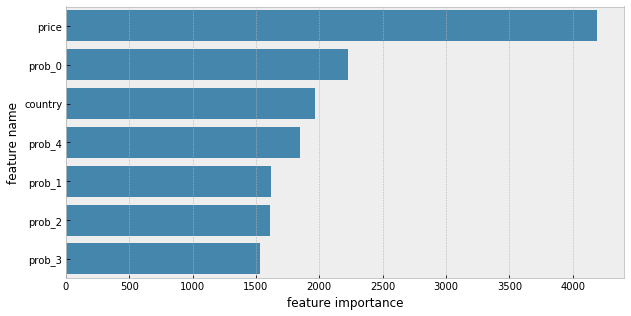

In [168]:
###FEATURE IMPORTANCE###
feature_imp=pd.DataFrame({'feature name':X_stack.columns, 
                          'feature importance':
                          model.feature_importances_}).sort_values('feature importance', ascending=False)

n_show=15
base_color = sns.color_palette()[0];

plt.figure(figsize = [10, n_show/3])
ax = sns.barplot(x = 'feature importance', 
                 y = 'feature name', 
                 data=feature_imp.iloc[:n_show, :], 
                 label='Feature Importance',
                 color=base_color)
ax.set_xlabel('feature importance');
# plt.tight_layout();
# plt.savefig('feature_importance_lgb_full.jpg', dpi=700);

As hyphothesized above in our exploratory data analysis, the variable _price_ turns out to be an important feature in determining a wine's rating. 

## MODEL STACKING: Save (Pickle) Model

See introductroy blog [post](https://towardsdatascience.com/deploy-your-data-science-model-7b81eea6c98).

### PICKLE

In [178]:
# use dump() method with pickle to write our model object into binary
import pickle

filename = 'model_lgbm_stacked_1.pkl'
file = open(filename, 'wb')
pickle.dump(model, file)

In [180]:
# load pickled model
loaded_pickle_model = pickle.load(open(filename, 'rb'))

In [181]:
# Sanity check: check loaded LGBM without HPO
cls = loaded_pickle_model
model_stack_load, acc_load = util.accuracy_summary2(cls, X_stack_train, X_stack_dev, Y_stack_train, Y_stack_dev)

Accuracy score on dev set: 68.91%


Note: The loaded model maintains all the model’s methods. You will not need to import the library again for it to run its methods, such as running a prediction.

### JOBLIB

In [182]:
from sklearn.externals import joblib

filename = 'model_lgbm_stacked_1.jlb'
joblib.dump(model, filename)

['model_lgbm_stacked_1.jlb']

In [183]:
# load model
loaded_joblib_model = joblib.load(filename)

In [184]:
# Sanity check: check loaded LGBM without HPO
cls = loaded_joblib_model
model_stack_load, acc_load = util.accuracy_summary2(cls, X_stack_train, X_stack_dev, Y_stack_train, Y_stack_dev)

Accuracy score on dev set: 68.91%


<a id='hpo'></a>

# HYPERPARAMETER OPTIMIZATION FOR STACKED LGBM MODEL

- In this section we try to improve our LGBM-based, stacked model using Bayesian hyperparameter optimization. 
- Under construction: In future work we may use self-defined, tailored objective functions and evaluation metrics, as described [here](https://github.com/microsoft/LightGBM/blob/master/examples/python-guide/advanced_example.py).

## HPO: Examples

In [185]:
# Create the learning rate
learning_rate = {'learning_rate': hp.loguniform('learning_rate', np.log(0.005), np.log(0.2))}

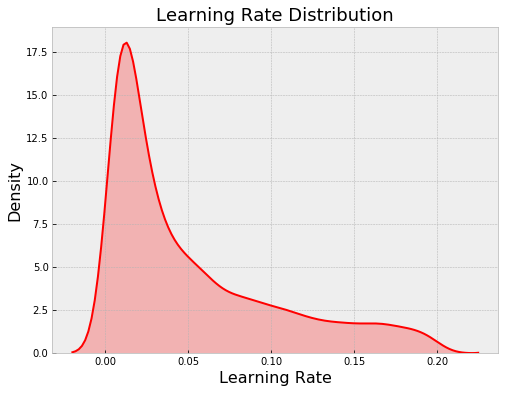

In [186]:
learning_rate_dist = []

# Draw 10000 samples from the learning rate domain
for _ in range(10000):
    learning_rate_dist.append(sample(learning_rate)['learning_rate'])
    
plt.figure(figsize = (8, 6))
sns.kdeplot(learning_rate_dist, color = 'red', linewidth = 2, shade = True);
plt.title('Learning Rate Distribution', size = 18); 
plt.xlabel('Learning Rate', size = 16); plt.ylabel('Density', size = 16);

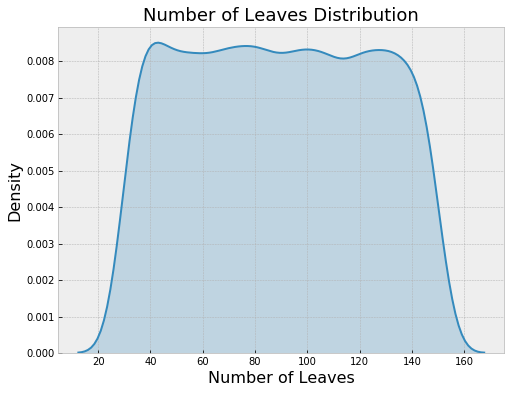

In [187]:
# Discrete uniform distribution
num_leaves = {'num_leaves': hp.quniform('num_leaves', 30, 150, 1)}
num_leaves_dist = []

# Sample 10000 times from the number of leaves distribution
for _ in range(10000):
    num_leaves_dist.append(sample(num_leaves)['num_leaves'])
    
# kdeplot
plt.figure(figsize = (8, 6))
sns.kdeplot(num_leaves_dist, linewidth = 2, shade = True);
plt.title('Number of Leaves Distribution', size = 18); 
plt.xlabel('Number of Leaves', size = 16); 
plt.ylabel('Density', size = 16);

In [188]:
# boosting type domain 
boosting_type = {'boosting_type': hp.choice('boosting_type', 
                                            [{'boosting_type': 'gbdt', 'subsample': hp.uniform('subsample', 0.5, 1)}, 
                                             {'boosting_type': 'dart', 'subsample': hp.uniform('subsample', 0.5, 1)},
                                             {'boosting_type': 'goss', 'subsample': 1.0}])}

# Draw a sample
params = sample(boosting_type)
params

{'boosting_type': {'boosting_type': 'dart', 'subsample': 0.6585798847593115}}

## HPO: Definition of Search Space

In [232]:
# Define the search space
space = {
    'class_weight': hp.choice('class_weight', [None, 'balanced']),
    'boosting_type': hp.choice('boosting_type', [{'boosting_type': 'gbdt', 'subsample': hp.uniform('gdbt_subsample', 0.5, 1)}, 
                                                 {'boosting_type': 'dart', 'subsample': hp.uniform('dart_subsample', 0.5, 1)},
                                                 {'boosting_type': 'goss', 'subsample': 1.0}]),
    'num_leaves': hp.quniform('num_leaves', 30, 150, 1),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.2)),
    'subsample_for_bin': hp.quniform('subsample_for_bin', 20000, 300000, 20000),
    'min_child_samples': hp.quniform('min_child_samples', 20, 500, 5),
    'reg_alpha': hp.uniform('reg_alpha', 0.0, 1.0),
    'reg_lambda': hp.uniform('reg_lambda', 0.0, 1.0),
    'colsample_bytree': hp.uniform('colsample_by_tree', 0.6, 1.0),
    'objective': 'multiclass',
    'num_class': 5, 
    'metric': 'multi_error'
}

In [233]:
# Sample from the full space
x = sample(space)

# Conditional logic to assign top-level keys
subsample = x['boosting_type'].get('subsample', 1.0)
x['boosting_type'] = x['boosting_type']['boosting_type']
x['subsample'] = subsample

x

{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 0.9985932478973599,
 'learning_rate': 0.05479924799887207,
 'metric': 'multi_error',
 'min_child_samples': 140.0,
 'num_class': 5,
 'num_leaves': 95.0,
 'objective': 'multiclass',
 'reg_alpha': 0.1086744194289263,
 'reg_lambda': 0.5323639327043591,
 'subsample': 0.8717872654031655,
 'subsample_for_bin': 80000.0}

In [234]:
# another random sample from the full space
x = sample(space)
subsample = x['boosting_type'].get('subsample', 1.0)
x['boosting_type'] = x['boosting_type']['boosting_type']
x['subsample'] = subsample
x

{'boosting_type': 'goss',
 'class_weight': 'balanced',
 'colsample_bytree': 0.821695690896876,
 'learning_rate': 0.10444609009966827,
 'metric': 'multi_error',
 'min_child_samples': 375.0,
 'num_class': 5,
 'num_leaves': 76.0,
 'objective': 'multiclass',
 'reg_alpha': 0.559189913482827,
 'reg_lambda': 0.3702122140950913,
 'subsample': 1.0,
 'subsample_for_bin': 280000.0}

## Cross Validation with Early Stopping in LightGBM
- The scikit-learn cross validation api does not include the option for early stopping.
- Therefore, we will use the LightGBM cross validation function with 100 early stopping rounds.
- To use this function, we need to create a dataset from our features and labels.

In [235]:
# Create a lgb dataset
train_set = lgb.Dataset(X_stack_train, label = Y_stack_train)

The ```cv``` function takes in the parameters, the training data, the number of training rounds, the number of folds, the metric, the number of early stopping rounds, and a few other arguments. We set the number of boosting rounds very high, but we will not actually train this many estimators because we are using early stopping to stop training when the validation score has not improved for 100 estimators.

## HPO: Run HPO with Hyperopt

In [217]:
def objective(params, n_folds=5):
    """Objective function for Gradient Boosting Machine Hyperparameter Optimization"""

    # Keep track of evals
    global ITERATION

    ITERATION += 1

    # Retrieve the subsample if present otherwise set to 1.0
    subsample = params['boosting_type'].get('subsample', 1.0)

    # Extract the boosting type
    params['boosting_type'] = params['boosting_type']['boosting_type']
    params['subsample'] = subsample

    # Make sure parameters that need to be integers are integers
    for parameter_name in ['num_leaves', 'subsample_for_bin', 'min_child_samples']:
        params[parameter_name] = int(params[parameter_name])

    start = timer()

    # Perform n_folds cross validation
    cv_results = lgb.cv(params, train_set, num_boost_round=10000, nfold=n_folds,
                        early_stopping_rounds=100, metrics='multi_error', seed=0)

    run_time = timer() - start

    # Extract the best score
    best_score = np.min(cv_results['multi_error-mean'])

    # Loss must be minimized
    loss = best_score

    # Boosting rounds that returned the highest cv score
    n_estimators = int(np.argmin(cv_results['multi_error-mean']) + 1)

    # Write to the csv file ('a' means append)
    of_connection = open(out_file, 'a')
    writer = csv.writer(of_connection)
    writer.writerow([loss, params, ITERATION, n_estimators, run_time])

    # Dictionary with information for evaluation
    return {'loss': loss, 'params': params, 'iteration': ITERATION,
            'estimators': n_estimators,
            'train_time': run_time, 'status': STATUS_OK}

In [239]:
def objective(params, n_folds=5):
    """Objective function for Gradient Boosting Machine Hyperparameter Optimization"""

    # Keep track of evals
    global ITERATION

    ITERATION += 1

    # Retrieve the subsample if present otherwise set to 1.0
    subsample = params['boosting_type'].get('subsample', 1.0)

    # Extract the boosting type
    params['boosting_type'] = params['boosting_type']['boosting_type']
    params['subsample'] = subsample

    # Make sure parameters that need to be integers are integers
    for parameter_name in ['num_leaves', 'subsample_for_bin', 'min_child_samples']:
        params[parameter_name] = int(params[parameter_name])

    start = timer()

    # Perform n_folds cross validation
    cv_results = lgb.cv(params, train_set, num_boost_round=10000, nfold=n_folds,
                        early_stopping_rounds=100, seed=0)

    run_time = timer() - start

    # Extract the best score
    # best_score = np.min(cv_results['multi_error-mean'])
    # Loss must be minimized
    # loss = best_score
    # Boosting rounds that returned the highest cv score
    # n_estimators = int(np.argmin(cv_results['multi_error-mean']) + 1)
    
    # Loss must be minimized
    get_metric = params["metric"]
    # Boosting rounds that returned the highest cv score
    n_estimators = int(np.argmin(cv_results[str(get_metric) + '-mean']))
    # Loss must be minimized
    loss = np.min(cv_results[str(get_metric) + '-mean'])

    # Write to the csv file ('a' means append)
    of_connection = open(out_file, 'a')
    writer = csv.writer(of_connection)
    writer.writerow([loss, params, ITERATION, n_estimators, run_time])

    # Dictionary with information for evaluation
    return {'loss': loss, 'params': params, 'iteration': ITERATION,
            'estimators': n_estimators,
            'train_time': run_time, 'status': STATUS_OK}

In [240]:
# optimization algorithm
tpe_algorithm = tpe.suggest

# Keep track of results
bayes_trials = Trials()

# File to save results
out_file = 'results/gbm_trials.csv'
of_connection = open(out_file, 'w')
writer = csv.writer(of_connection)

# Write the headers to the file
writer.writerow(['loss', 'params', 'iteration', 'estimators', 'train_time'])
of_connection.close()

# Global variable
global ITERATION

ITERATION = 0

# Run optimization
best = fmin(fn = objective, space = space, algo = tpe.suggest, 
            max_evals = 75, trials = bayes_trials, rstate = np.random.RandomState(0))

100%|██████████| 75/75 [3:18:20<00:00, 51.18s/it, best loss: 0.28024114125992383]  


In [241]:
# Sort the trials with lowest loss first
bayes_trials_results = sorted(bayes_trials.results, key = lambda x: x['loss'])
bayes_trials_results[:2]

[{'estimators': 693,
  'iteration': 73,
  'loss': 0.28024114125992383,
  'params': {'boosting_type': 'gbdt',
   'class_weight': 'balanced',
   'colsample_bytree': 0.6909120586187972,
   'learning_rate': 0.020081722981675133,
   'metric': 'multi_error',
   'min_child_samples': 320,
   'num_class': 5,
   'num_leaves': 35,
   'objective': 'multiclass',
   'reg_alpha': 0.7132543167292813,
   'reg_lambda': 0.8937453799629261,
   'subsample': 0.9149946833831376,
   'subsample_for_bin': 200000,
   'verbose': 1},
  'status': 'ok',
  'train_time': 65.27067891601473},
 {'estimators': 480,
  'iteration': 66,
  'loss': 0.28027063923528517,
  'params': {'boosting_type': 'gbdt',
   'class_weight': 'balanced',
   'colsample_bytree': 0.6476958905670431,
   'learning_rate': 0.02503351732346291,
   'metric': 'multi_error',
   'min_child_samples': 345,
   'num_class': 5,
   'num_leaves': 33,
   'objective': 'multiclass',
   'reg_alpha': 0.6599434763127459,
   'reg_lambda': 0.4679651531631782,
   'subsamp

In [242]:
results = pd.read_csv('results/gbm_trials.csv')

# Sort with best scores on top and reset index for slicing
results.sort_values('loss', ascending = True, inplace = True)
results.reset_index(inplace = True, drop = True)
results.head()

,loss,params,iteration,estimators,train_time
0,0.280241,"{'boosting_type': 'gbdt', 'num_class': 5, 'min...",73,693,65.270679
1,0.280271,"{'boosting_type': 'gbdt', 'num_class': 5, 'min...",66,480,58.700152
2,0.280315,"{'boosting_type': 'gbdt', 'num_class': 5, 'min...",63,666,61.284518
3,0.280344,"{'boosting_type': 'gbdt', 'num_class': 5, 'min...",9,641,54.837907
4,0.280411,"{'boosting_type': 'gbdt', 'num_class': 5, 'min...",75,501,49.531265


In [243]:
import ast

# Extract the ideal number of estimators and hyperparameters
best_bayes_estimators = int(results.loc[0, 'estimators'])
best_bayes_params = ast.literal_eval(results.loc[0, 'params']).copy()

# Re-create the best model and train on the training data
best_bayes_model = lgb.LGBMClassifier(n_estimators=best_bayes_estimators, n_jobs = -1, 
                                      random_state = 0, **best_bayes_params)
best_bayes_model.fit(X_stack_train, Y_stack_train)

LGBMClassifier(boosting_type='gbdt', class_weight='balanced',
        colsample_bytree=0.6909120586187972,
        learning_rate=0.020081722981675133, max_depth=-1,
        metric='multi_error', min_child_samples=320,
        min_child_weight=0.001, min_split_gain=0.0, n_estimators=693,
        n_jobs=-1, num_class=5, num_leaves=35, objective='multiclass',
        random_state=0, reg_alpha=0.7132543167292813,
        reg_lambda=0.8937453799629261, silent=True,
        subsample=0.9149946833831376, subsample_for_bin=200000,
        subsample_freq=0, verbose=1)

In [244]:
# Evaluate on the testing data 
cls = best_bayes_model
model_bayes, acc_bayes = util.accuracy_summary2(cls, X_stack_train, X_stack_dev, Y_stack_train, Y_stack_dev)

Accuracy score on dev set: 64.38%


In [245]:
# Evaluate on the testing data 
preds = best_bayes_model.predict(X_stack_dev)
print('The best model from Bayes optimization scores {:.5f} acc on the test set.'.format(accuracy_score(Y_stack_dev, preds)))
print('This was achieved after {} search iterations.'.format(results.loc[0, 'iteration']))

The best model from Bayes optimization scores 0.64381 acc on the test set.
This was achieved after 73 search iterations.


<a id='appendix'></a>

# APPENDIX: Early Stopping with LGBM

Interesting read [here](https://www.kaggle.com/nicapotato/multi-class-lgbm-cv-and-seed-diversification).

In [229]:
lgbm_params =  {
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'multiclass',
    'num_class': 5,
    'metric': ['multi_error'],
    "learning_rate": 0.05,
     "num_leaves": 60,
     "max_depth": 9,
     "feature_fraction": 0.45,
     "bagging_fraction": 0.3,
     "reg_alpha": 0.15,
     "reg_lambda": 0.15,
     "min_child_weight": 0
                }

In [230]:
# Find Optimal Parameters / Boosting Rounds
lgb_cv = lgb.cv(
    params = lgbm_params,
    train_set = train_set,
    num_boost_round=2000,
    stratified=True,
    nfold = 5,
    verbose_eval=50,
    seed = 23,
    early_stopping_rounds=75)

loss = lgbm_params["metric"][0]
optimal_rounds = np.argmin(lgb_cv[str(loss) + '-mean'])
best_cv_score = min(lgb_cv[str(loss) + '-mean'])

print("\nOptimal Round: {}\nOptimal Score: {} + {}".format(
    optimal_rounds,best_cv_score,lgb_cv[str(loss) + '-stdv'][optimal_rounds]))

results = results.append({"Rounds": optimal_rounds,
                          "Score": best_cv_score,
                          "STDV": lgb_cv[str(loss) + '-stdv'][optimal_rounds],
                          "LB": None,
                          "Parameters": lgbm_params}, ignore_index=True)

[50]	cv_agg's multi_error: 0.285206 + 0.00161098
[100]	cv_agg's multi_error: 0.282063 + 0.0015874
[150]	cv_agg's multi_error: 0.281451 + 0.00161893
[200]	cv_agg's multi_error: 0.281709 + 0.00156847

Optimal Round: 144
Optimal Score: 0.28124446705620254 + 0.001654376948620659
